<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@4.1.3/dist/css/bootstrap.min.css" integrity="sha384-MCw98/SFnGE8fJT3GXwEOngsV7Zt27NXFoaoApmYm81iuXoPkFOJwJ8ERdknLPMO" crossorigin="anonymous">

# SmartPay <img src="https://c.tenor.com/CigpzapemsoAAAAi/hi-robot.gif" align="right" width="100px" height="25px" />

### Autor: Fellipe Gomes ([blog](http://gomesfellipe.github.io/))
### Data: 12/07/2022
### Objetivo: Construir um modelo estatístico que auxilie na valoração do trabalho de um cientista de dados.

<img src="https://storage.googleapis.com/kaggle-datasets-images/2043193/3389022/2c02116d8958b741983db25871c8d92a/dataset-cover.png?t=2022-03-31-23-12-06" width="600px" height="400px" align="center">

Este notebook foi fortemente inspirado em um antigo que desenvolvi para a pesquisa do DataHackers feita durante Novembro de 2019: 

→ [XGBoost para prever salário de cientistas de dados](https://www.kaggle.com/code/gomes555/xgboost-para-prever-sal-rio-de-cientistas-de-dados). 

Espero que gostem deste notebook! 🤘

In [1]:
# carregar dependencias
library(gamlss)
library(tidyverse)
library(patchwork)

# definir tema das imagens
theme_set(theme_bw()+theme(text = element_text(size=22)))

# funcao auxiliar para exibir plot
fig <- function(width, heigth){
    # borrowed from https://www.kaggle.com/getting-started/105201
    options(repr.plot.width = width, repr.plot.height = heigth)
}

# desligar avisos
options(warn=-1)

Loading required package: splines

Loading required package: gamlss.data


Attaching package: ‘gamlss.data’


The following object is masked from ‘package:datasets’:

    sleep


Loading required package: gamlss.dist

Loading required package: MASS

Loading required package: nlme

Loading required package: parallel

Registered S3 method overwritten by 'gamlss':
  method   from
  print.ri bit 

 **********   GAMLSS Version 5.4-1  ********** 

For more on GAMLSS look at https://www.gamlss.com/

Type gamlssNews() to see new features/changes/bug fixes.


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks nlme::collapse()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ dplyr::se

# Definição do problema de negócio
---

## Situação

A busca por cientistas de dados e profissionais da área está alta, ainda mais com a crescente demanda das empresas por soluções analíticas. Isso faz com que a <b>movimentação destes profissionais</b> seja bastante comum, dificultando sua retenção. ([veja esta notícia](https://valor.globo.com/carreira/noticia/2022/03/18/cientista-de-dados-carreira-aquecida-e-com-salarios-em-alta-saiba-mais.ghtml))

## Problema

A medida que a sociedade gera e captura mais dados, existe uma <b>demanda</b> cada vez maior por este tipo de profissional, que é acompanhada de uma baixa <b>oferta</b>. 

Veja a seguir uma relação entre dados x analistas [(A)](http://www.delphianalytics.net/more-data-than-analysts-the-real-big-data-problem/) e também como o número de formados em estatística [(B)](http://www.conre3.org.br/portal/estatistica-sobram-oportunidades-mas-inep-registra-poucos-formados/) (uma das diversas áreas que podem preparar um cientista de dados) não vêm acompanhando as tendências de crescimendo de outros países, como Estados Unidos:

<img src="https://i.im.ge/2022/07/10/up5qa0.png" width="600px" height="400px">


<button style="margin-left: 17em"><a href="http://www.delphianalytics.net/more-data-than-analysts-the-real-big-data-problem/">Fonte (A)</a></button>
<button style="margin-left: 16em"><a href="http://www.conre3.org.br/portal/estatistica-sobram-oportunidades-mas-inep-registra-poucos-formados/">Fonte (B)</a></button>

## Implicação

Em um cenário assim, estimar um salário condizente com o mercado pode se tornar um grande desafio pois é uma profissão relativamente nova e existe pouca informação disponível em larga escala que auxilie na tomada de decisão.

Por outro lado, obter mecanismos e insights sobre o mercado podem fornecer uma <b>vantagem competitiva</b> a qualquer empresa que esteja disposta a reter bons funcionários.

## Necessidade

Para auxiliar gestores e profissionais de RH responsáveis pelas contratações e promoções, proponho ajustar um modelo que seja capaz de <b>estimar a faixa do salário</b> de um cientista de dados basedos em algumas informações (técnicas) do candidato/colaborador bem como fornecer insights sobre quais características impactam mais no salário do profissional que trabalha com dados (exclusivamente baseado nos dados fornecidos oficialmente pela comunidade [DataHackers](https://datahackers.com.br/) na pesquisa [State of Data Brazil 2021](https://www.stateofdata.com.br/))


<div class="alert alert-warning"> 
<div style="color: rgb(0, 0, 0);"><strong>⚠️  Disclaimer</strong> </div>
    
<div style="color: rgb(0, 0, 0);"> É importante enfatizar que para a construção de um modelo <b>justo</b> (<a href="https://fairmlbook.org/index.html">veja mais sobre <i>fairness</i></a>), é extremamente importante a utilização de dados bem amostrados pois o velho slogan “<i>garbage in, garbage out</i>” sem dúvida se aplica à prática de aprendizado de máquina, assim como o bordão relacionado “<i><b>bias in, bias out</b></i>”.
</div>


# Carregar dados
---

Este notebook é baseado apenas nos dados fornecidos oficialmente pela comunidade [DataHackers](https://datahackers.com.br/) na pesquisa [State of Data Brazil 2021](https://www.stateofdata.com.br/) , que foi realizada entre 18 de outubro de 2021 e 6 de dezembro de 2021 e reuniu indicadores
relacionados a perfil demográfico, formação, atuação no setor, remuneração, rotatividade e fatores de
satisfação no ambiente de trabalho, incluindo o impacto do trabalho remoto nas preferências
profissionais de 2.645 respondentes de todo o Brasil.

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Algumas restrições impostas aos dados:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ A pesquisa foi realizada entre 18 de outubro de 2021 e 6 de dezembro de 2021;</div>
<div style="color: rgb(0, 0, 0);">→ O dataset foi anonimizado;</div>
<div style="color: rgb(0, 0, 0);">→ Alguns outliers que poderiam identificar o entrevistado e, portanto, nem todos os dados coletados na pesquisa estarão disponíveis aqui;</div>
<div style="color: rgb(0, 0, 0);">→ Estados com menor incidência de resposta, como aqueles das regiões Norte, Nordeste e Centro-Oeste terão apenas sua região indicada no dataset (tambem como consequencia da anonimização);</div>
<div style="color: rgb(0, 0, 0);">→ As perguntas cujas respostas são multi-valoradas ocupam mais de uma coluna no dataset;</div>
<div style="color: rgb(0, 0, 0);">→ Categorias foram convertidas para dummy.</div>
</div>

&nbsp;

É muito interessante poder analisar estes dados com mais de 2.500 respostas em um esforço para conhecermos melhor esse mercado relativamente novo e extremamente aquecido, porém, algumas questões precisam ser levantadas sobre o <b>processo gerador</b> destes dados (amostragem):

<div style="display: flex;flex: row;">
    
<div class="alert alert-danger"> 
<strong><div style="color: rgb(0, 0, 0);">⚠️  Pontos de atenção sobre a base de dados:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Deve ter sido bem difícil de fazer o desenho amostral desta pesquisa pois não temos informações sobre a "população" do mercado, queria entender melhor como foi a metodologia de pesquisa para conhecer os limites da extrapolação dos resultados;</div>
<div style="color: rgb(0, 0, 0);">→ Pelo que parece, não houve um critério amostral na escolha de quem responderia o questionário, assim, todos que quisessem poderiam responder e encaminhar para seus colegas. Com isso, existe alguma chance de haver viés amostral na pesquisa pois acabaria sendo uma amostra por conveniência (não probabilística);</div>
<div style="color: rgb(0, 0, 0);">→ Mas de qualquer forma, estes dados são extremamente úteis e podem trazer insights muito relevantes.</div>
</div>

<!---<div style="text-align: left; margin-left: 30px;">
<img src="https://www.netquest.com/hubfs/Imported_Blog_Media/muestreo-no-probabilistico.jpg" width="600px" height="400px">
</div>-->

Deixando essas questões de lado, vamos analisar os resultados!

In [2]:
# carregar dados
df_full <- read_csv("../input/state-of-data-2021/State of Data 2021 - Dataset - Pgina1.csv") %>%  
  janitor::clean_names() %>% 
  # minor fix
  mutate(p2_f_cargo_atual = ifelse(p2_f_cargo_atual=="Arquiteto de dados", 'Arquiteto de Dados', p2_f_cargo_atual),
         p2_b_setor = ifelse(p2_b_setor=='consultoria', 'Consultoria', p2_b_setor)) 

# remover colunas de respostas multi-valoradas
df <- df_full %>% 
  select(-one_of(c(
    colnames(.) %>% .[str_detect(., "p1_a_\\w_")],
    colnames(.) %>% .[str_detect(., "p1_e_\\w_")],
    colnames(.) %>% .[str_detect(., "p1_g_b_\\w_")],
    colnames(.) %>% .[str_detect(., "p2_l_\\w_")],
    colnames(.) %>% .[str_detect(., "p2_o_\\w_")],
    colnames(.) %>% .[str_detect(., "p3_b_\\w_")],
    colnames(.) %>% .[str_detect(., "p3_c_\\w_")],
    colnames(.) %>% .[str_detect(., "p3_d_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_b_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_c_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_d_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_e_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_f_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_f_z\\w_")],
    colnames(.) %>% .[str_detect(., "p4_g_\\w_")],
    colnames(.) %>% .[str_detect(., "p4_h_\\w_")],
    colnames(.) %>% .[str_detect(., "p6_a_\\w_")],
    colnames(.) %>% .[str_detect(., "p6_b_\\w_")],
    colnames(.) %>% .[str_detect(., "p6_g_\\w_")],
    colnames(.) %>% .[str_detect(., "p6_h_\\w_")],
    colnames(.) %>% .[str_detect(., "p7_a_\\w_")],
    colnames(.) %>% .[str_detect(., "p7_b_\\w_")],
    colnames(.) %>% .[str_detect(., "p7_c_\\w_")],
    colnames(.) %>% .[str_detect(., "p7_d_\\w_")],
    colnames(.) %>% .[str_detect(., "p8_a_\\w_")],
    colnames(.) %>% .[str_detect(., "p8_b_\\w_")],
    colnames(.) %>% .[str_detect(., "p8_c_\\w_")],
    colnames(.) %>% .[str_detect(., "p8_d_\\w_")],
    colnames(.) %>% .[str_detect(., "p9_a_\\w_")]
  )
  ))

Rows: 2645 Columns: 356
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (56): ('P0', 'id'), ('P1_a_a ', 'Faixa idade'), ('P1_b ', 'Genero'), ('...
dbl (300): ('P1_a ', 'Idade'), ('P1_g_c ', 'Mudou de Estado?'), ('P2_d ', 'G...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Features elegíveis 

O critério para elegibilidade das features utilizado aqui foi basicamente (e humildemente) pensar quais perguntas um **entrevistador não enviesado** faria à um entrevistado. 

|  Indice | Pergunda | Seleção |
|:--|:--|:--:|
|ID|id | <span style="color: red;">✗</span> |
|Dados Demográficos| Idade  | <span style="color: red;">✗</span> |
|Dados Demográficos| Gênero | <span style="color: red;">✗</span> |
|Dados Demográficos| Estado onde mora | <span style="color: green;">✔</span>  |
|Dados Demográficos| UF onde mora | <span style="color: red;">✗</span> |
|Dados Demográficos| Região onde mora | <span style="color: red;">✗</span> |
|Dados Demográficos| Região de origem | <span style="color: red;">✗</span> |
|Dados Demográficos| Mudou de estado | <span style="color: red;">✗</span> |
|Dados Demográficos| Nível de ensino | <span style="color: green;">✔</span>  |
|Dados Demográficos| Área de formação | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Qual sua situação atual de trabalho | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Setor | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Número de funcionários | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Gestor | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Cargo como gestor | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Cargo atual | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Nível | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Faixa salarial | 🎯  |
|Dados sobre carreira| Quanto tempo de experiência na área de dados voce tem |  <span style="color: green;">✔</span>  |
|Dados sobre carreira| Quanto tempo de experiência na área de ti engenharia de software voce teve antes de comecar a trabalhar na area de dados |  <span style="color: green;">✔</span>  |
|Dados sobre carreira| Você esta satisfeito na sua empresa atual | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Qual o principal motivo da sua insatisfação com a empresa atual | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Voce participou de entrevistas de emprego nos ultimos 6 meses | <span style="color: red;">✗</span> |
|Dados sobre carreira| Voce pretende mudar de emprego nos proximos 6 meses | <span style="color: red;">✗</span> |
|Dados sobre carreira| Quais os principais critérios que voce leva em consideração no momento de decidir onde trabalhar | <span style="color: red;">✗</span> |
|Dados sobre carreira| Atualmente qual a sua forma de trabalho | <span style="color: red;">✗</span> |
|Dados sobre carreira| Qual a forma de trabalho ideal para voce | <span style="color: green;">✔</span>  |
|Dados sobre carreira| Caso sua empresa decida pelo modelo 100% presencial qual sera sua atitude | <span style="color: red;">✗</span> |
|Desafios dos gestores| Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje | <span style="color: green;">✔</span>  |
|Desafios dos gestores| Quais desses papeis cargos fazem parte do time ou *chapter* de dados da sua empresa | <span style="color: green;">✔</span>  |
|Desafios dos gestores| Quais dessas responsabilidades fazem parte da sua rotina atual de trabalho como gestor | <span style="color: red;">✗</span> |
|Desafios dos gestores| Quais são os 3 maiores desafios que voce tem como gestor no atual momento | <span style="color: red;">✗</span> |
|Conhecimentos na área| Mesmo que esse não seja seu cargo formal voce considera que sua atuação no dia a dia reflete alguma das opções listadas abaixo | <span style="color: red;">✗</span> |
|Conhecimentos na área| Atuação | <span style="color: green;">✔</span>  |
|Conhecimentos na área| Quais das fontes de dados listadas você ja analisou ou processou no trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos na área| Entre as fontes de dados listadas quais voce utiliza na maior parte do tempo |  <span style="color: red;">✗</span> |
|Conhecimentos na área| Quais das linguagens listadas abaixo você utiliza no trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos na área| Entre as linguagens listadas abaixo qual e a que voce mais utiliza no trabalho | <span style="color: red;">✗</span> |
|Conhecimentos na área| Quais dos bancos de dados fontes de dados listados abaixo voce utiliza no trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos na área| Quais das opções de cloud listadas abaixo voce utiliza no trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos na área| Quais as ferramentas de business intelligence voce utiliza no trabalho | <span style="color: green;">✔</span>  |
|Objetivos na área| Qual oportunidade você esta buscando | <span style="color: red;">✗</span> |
|Objetivos na área| A quanto tempo voce busca uma oportunidade na área de dados | <span style="color: red;">✗</span> |
|Objetivos na área| Como tem sido a busca por um emprego na área de dados | <span style="color: red;">✗</span> |
|Conhecimentos em DE| Quais das opcões abaixo fazem parte da sua rotina no trabalho atual como engenheiro de dados | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Quais as ferramentas tecnologias de etl que voce utiliza no trabalho como data engineer | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Sua organização possui um data lake | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Qual tecnologia utilizada como plataforma do data lake | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Sua organização possui um data warehouse | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Qual tecnologia utilizada como plataforma do data warehouse | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Quais as ferramentas de gestao de qualidade de dados metadados e catálogo de dados voce utiliza no trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos em DE| Em qual das opções abaixo voce gasta a maior parte do seu tempo | <span style="color: green;">✔</span>  |
|Conhecimentos em DA| Quais das opções abaixo fazem parte da sua rotina no trabalho atual com análise de dados | <span style="color: green;">✔</span>  |
|Conhecimentos em DA| Quais as ferramentas tecnologias de etl que voce utiliza no trabalho como data analyst | <span style="color: green;">✔</span>  |
|Conhecimentos em DA| Sua empresa utiliza alguma das ferramentas listadas para dar mais autonomia em análise de dados para as áreas de negócio | <span style="color: green;">✔</span>  |
|Conhecimentos em DA| Em qual das opções abaixo voce gasta a maior parte do seu tempo de trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos em DS| Quais das opções abaixo fazem parte da sua rotina no trabalho atual com ciência de dados | <span style="color: green;">✔</span>  |
|Conhecimentos em DS| Quais as tecnicas e metodos listados abaixo voce costuma utilizar no trabalho | <span style="color: green;">✔</span>  |
|Conhecimentos em DS| Quais dessas tecnologias fazem parte do seu dia a dia como cientista de dados | <span style="color: green;">✔</span>  |
|Conhecimentos em DS| Em qual das opções abaixo voce gasta a maior parte do seu tempo no trabalho | <span style="color: green;">✔</span>  |
|Sobre a comunidade| Quais das iniciativas do data hackers que voce ja acessou acompanhou | <span style="color: red;">✗</span> |



<div class="alert alert-warning"> 
<strong><div style="color: rgb(0, 0, 0);">⚠️  Alguns comentários:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ O modelo <b>não deve fazer distinção de idade e gênero</b>, por isso essas features foram removidas;</div>
<div style="color: rgb(0, 0, 0);">→ Não importa onde o funcionário nasceu, mas a região onde reside foi mantida para passar alguma informação geográfica para o modelo já que algumas vagas são 100% presenciais (imho, infelizmente);</div>
<div style="color: rgb(0, 0, 0);">→ Apesar da área ser multidisciplinar, alguns <i>backgrounds</i> têm grande valor para a área;</div>
<div style="color: rgb(0, 0, 0);">→ A proposta deste notebook é contruir uma ferramenta para auxiliar na contratação de cientistas de dados e por isso, algumas features foram desconsideradas;</div>
<div style="color: rgb(0, 0, 0);">→ Me preocupou um pouco (para a proposta do modelo) o fato de ~30% não terem respondido o cargo atual.</div>
</div>

## Seleção de instâncias

Como o objetivo é construir um modelo que seja capaz de estimar o salário de um funcionário que trabalhe com dados, algumas instâncias podem não fazer sentido. Por exemplo, aqueles que não possuem salário (na maioria estudantes), aqueles que preencheram que recebem salários superiores à R\$40.000,00, ou também aqueles que não moram no Brasil (em teoria eles não devem estar recebendo em "reais").

Vejamos o perfil daqueles que não informaram o salário no questionário:

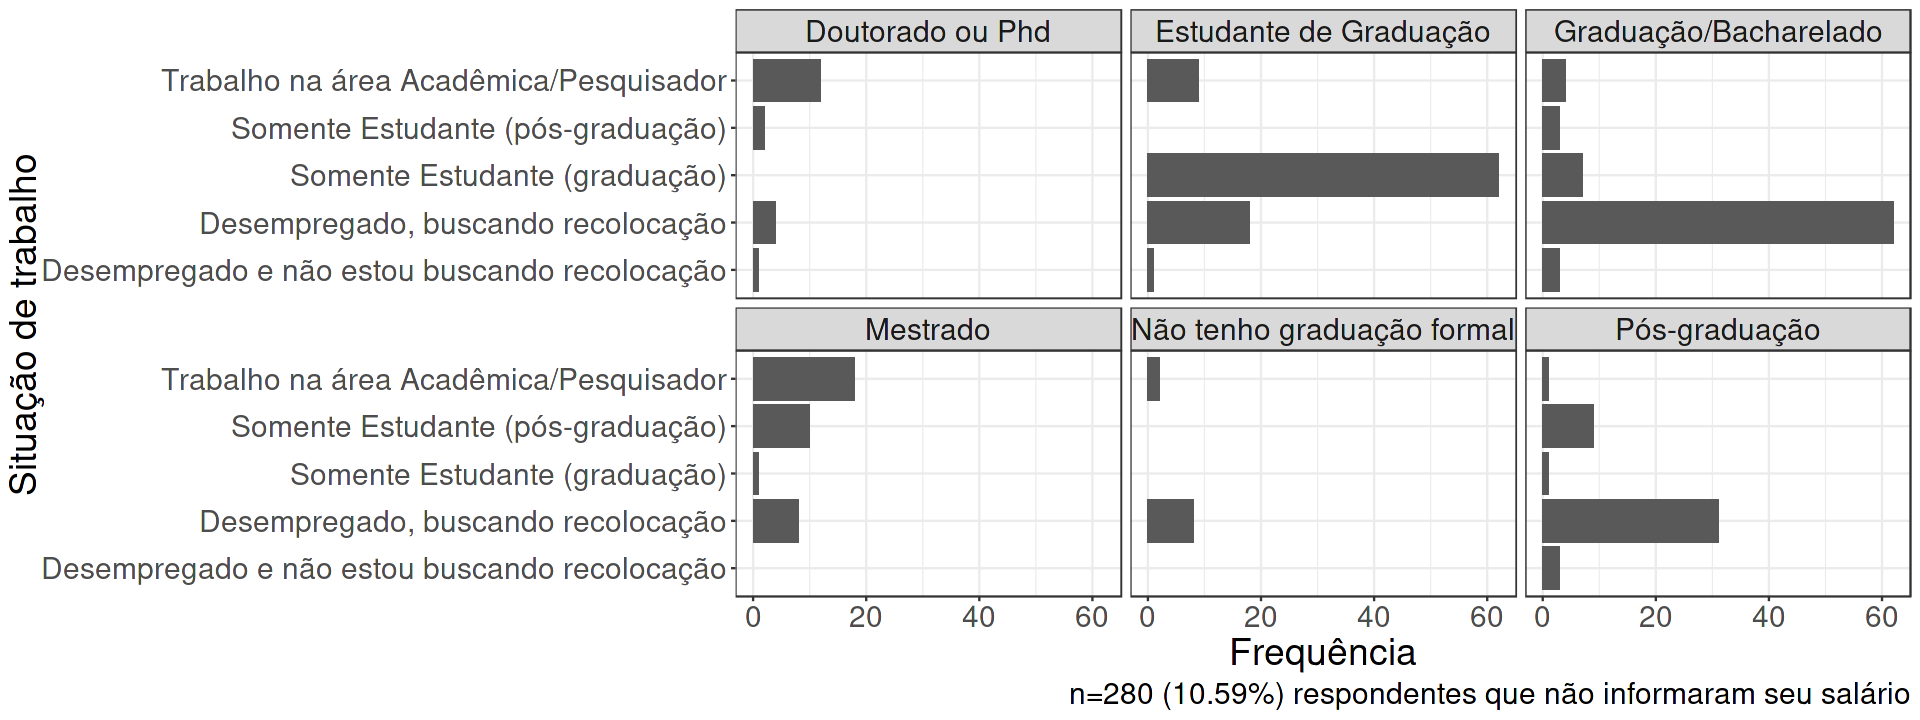

In [3]:
fig(16, 6)

# numero de linhas descartadas por ausencia de salario
n_drop <- df %>% filter(is.na(p2_h_faixa_salarial)) %>% nrow()

# plot
df %>% 
    filter(is.na(p2_h_faixa_salarial)) %>% 
    count(`Nível de ensino` = p1_h_nivel_de_ensino, 
          `Situação de trabalho`=p2_a_qual_sua_situacao_atual_de_trabalho) %>% 
    ggplot(aes(x = `Situação de trabalho`, y = n))+ 
    geom_bar(stat="identity")+
    facet_wrap(~`Nível de ensino`)+
    coord_flip()+
    labs(#title="Perfil dos respondentes que não foram considerados na modelagem",
        y="Frequência", caption = glue::glue("n={n_drop} ({round(n_drop/nrow(df)*100, 2)}%) respondentes que não informaram seu salário"))

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Naturalmente, estudantes de graduação/bacharelado estão buscando ativamente buscando recolocação;</div>
<div style="color: rgb(0, 0, 0);">→ Um número relativamente alto de pessoas que estão "buscando realocação" estão fazendo pós-graduação, seja para aumetar suas chances de contratação ou para se aperfeiçoar enquanto procura por um emprego.</div>
</div>

In [4]:
# filtrar apenas dados validos para o modelo
df <- df %>% filter(!is.na(p2_h_faixa_salarial),
                    (p2_h_faixa_salarial != "Acima de R$ 40.001/mês"),
                    (p1_e_estado_onde_mora!='Fora do Brasil'))

Para minha surpresa, durante o estudo dos resíduos na modelagem pude perceber que existiam alguns estagiários ganhando salários entre R\\$2.000 e R\$4.000 (um salário relativamente alto para estagiário) e como (normalmente) esses salários são meio fixos e não contam para a folha de funcionários foi necessário estudar um pouco mais a fundo as distribuição da faixa salárial de acordo com a situação de trabalho:

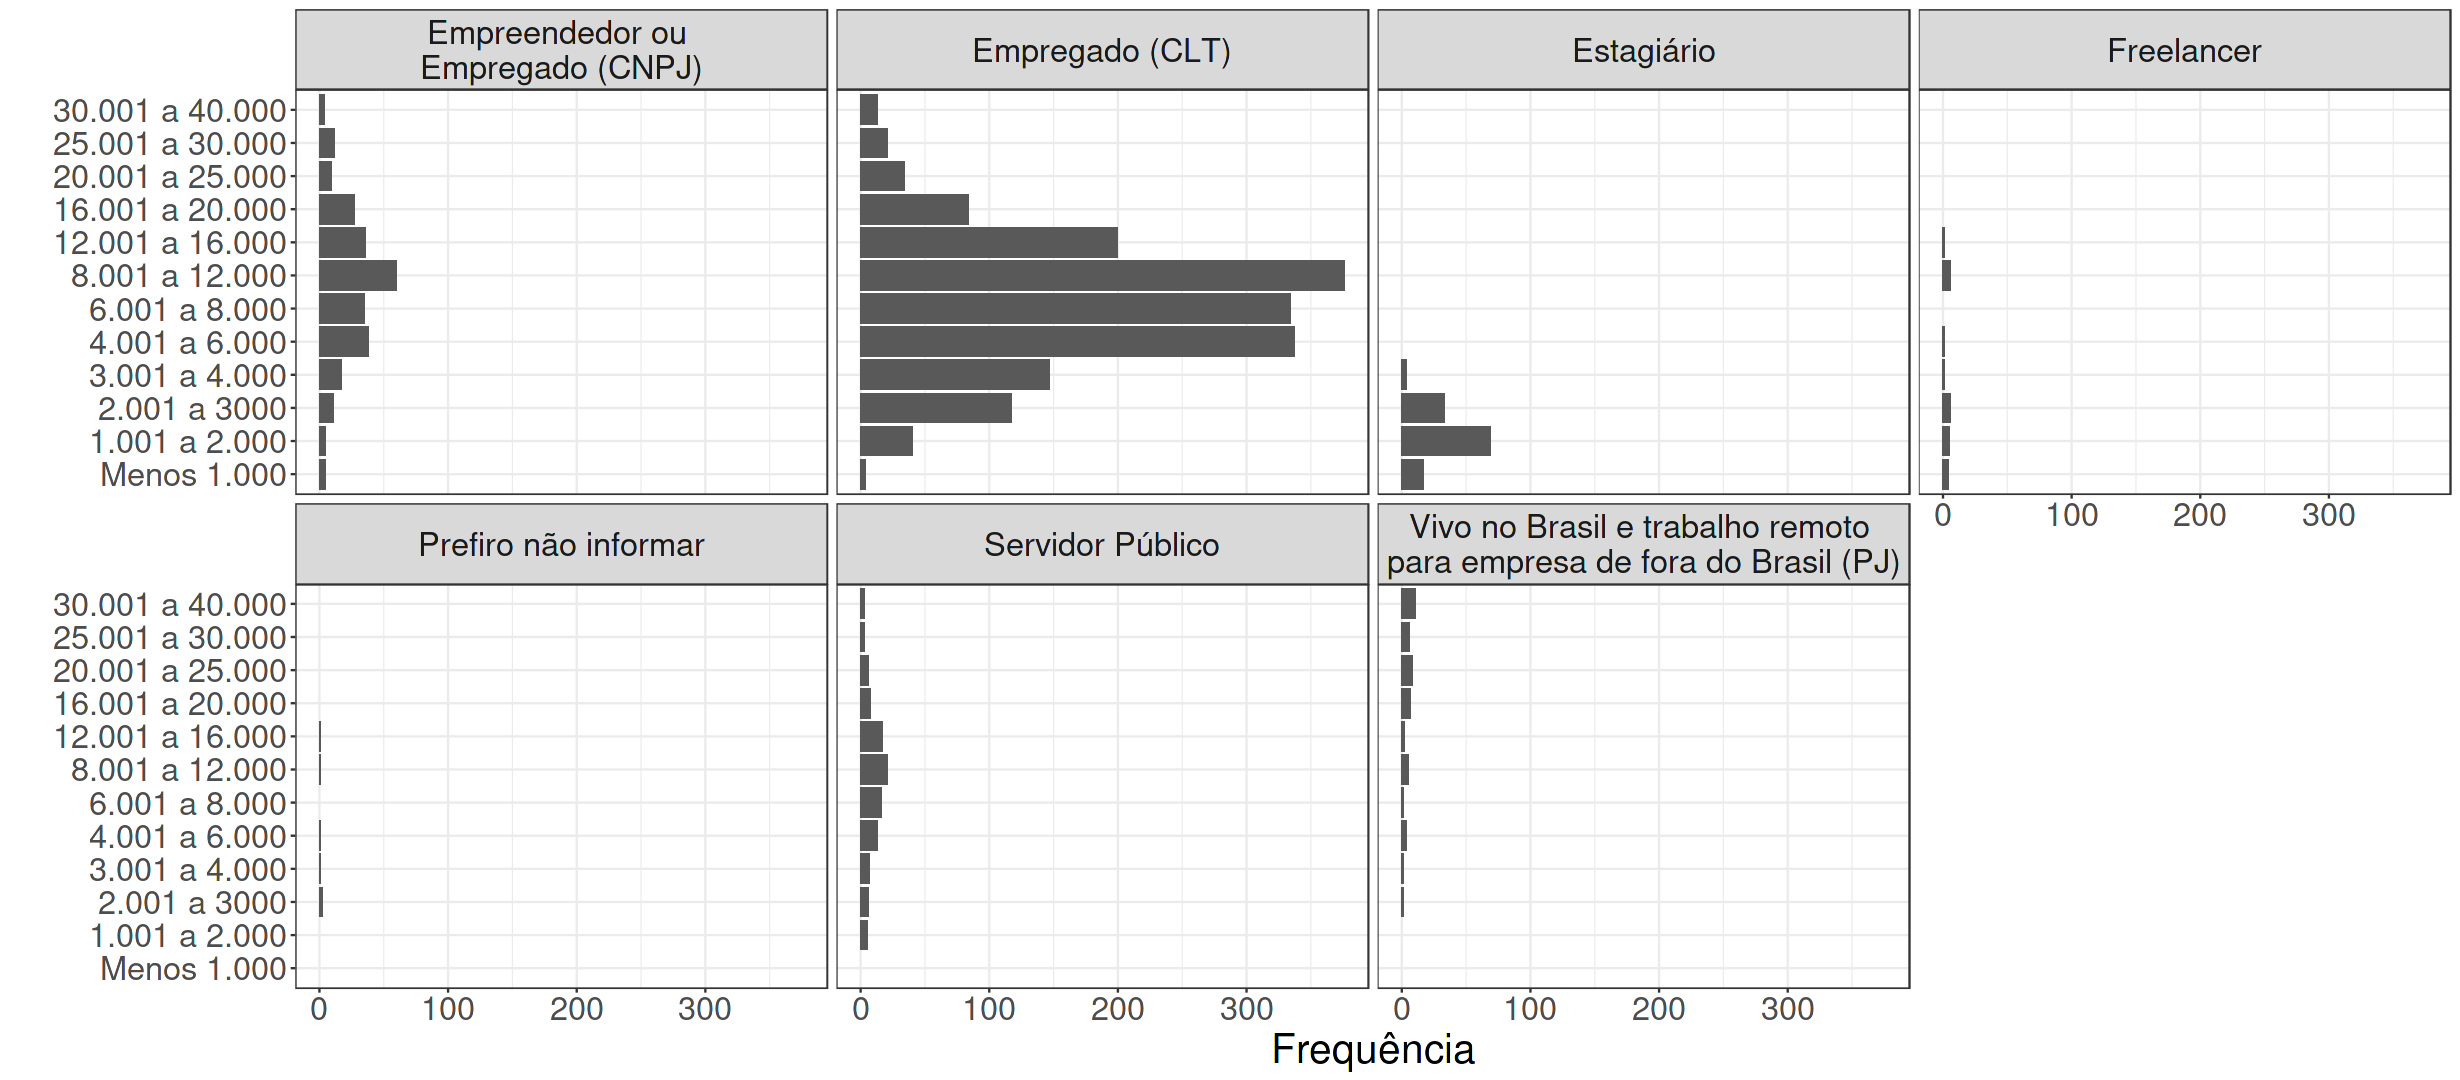

In [5]:
fig(20.5, 9)
df %>% 
    mutate(p2_h_faixa_salarial = str_remove_all(p2_h_faixa_salarial, "de |/mês|R\\$ "))%>%
    mutate(p2_h_faixa_salarial = factor(p2_h_faixa_salarial, levels = c("Menos 1.000",
                                                                        "1.001 a 2.000",
                                                                        "2.001 a 3000",
                                                                        "3.001 a 4.000",
                                                                        "4.001 a 6.000",
                                                                        "6.001 a 8.000",
                                                                        "8.001 a 12.000",
                                                                        "12.001 a 16.000",
                                                                        "16.001 a 20.000",
                                                                        "20.001 a 25.000",
                                                                        "25.001 a 30.000",
                                                                        "30.001 a 40.000")))%>% 
count(p2_a_qual_sua_situacao_atual_de_trabalho, p2_h_faixa_salarial) %>%
mutate(p2_a_qual_sua_situacao_atual_de_trabalho = ifelse(p2_a_qual_sua_situacao_atual_de_trabalho == "Vivo no Brasil e trabalho remoto para empresa de fora do Brasil (PJ)",
                                                        "Vivo no Brasil e trabalho remoto \npara empresa de fora do Brasil (PJ)", p2_a_qual_sua_situacao_atual_de_trabalho)) %>%
mutate(p2_a_qual_sua_situacao_atual_de_trabalho = ifelse(p2_a_qual_sua_situacao_atual_de_trabalho == "Empreendedor ou Empregado (CNPJ)",
                                                        "Empreendedor ou \nEmpregado (CNPJ)", p2_a_qual_sua_situacao_atual_de_trabalho)) %>%
    ggplot(aes(x = p2_h_faixa_salarial, y = n))+
    geom_bar(stat='identity')+
    facet_wrap(~p2_a_qual_sua_situacao_atual_de_trabalho, nrow=2)+
    labs(y="Frequência", x="")+ 
    theme(text = element_text(size=24))+
    coord_flip()


<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Todos os Estagiários serão removidos da base de treino;</div>
<div style="color: rgb(0, 0, 0);">→ Além disso, os funcionários que vivem no brasil mas trabalham para fora não deveriam estar na base de treino pois devem receber em dolar, adicionando ruído ao modelo e foge o escopo da definição do problema.</div>
</div>

## Tratamento da target

O salário está discretizado na base, o que deixa algumas opções de tratamento como simplesmente deixar como está e usar uma abordagem de modelo multinomial ou converter os valores em uma escala ordinal ou ainda converter em uma escala ordinal respeitando as faixas de salário (talvez possa ser aproximada por uma distribuição Poisson ou Binomial Negativa).

Vejamos a distribuição dos dados nestes dois formatos:

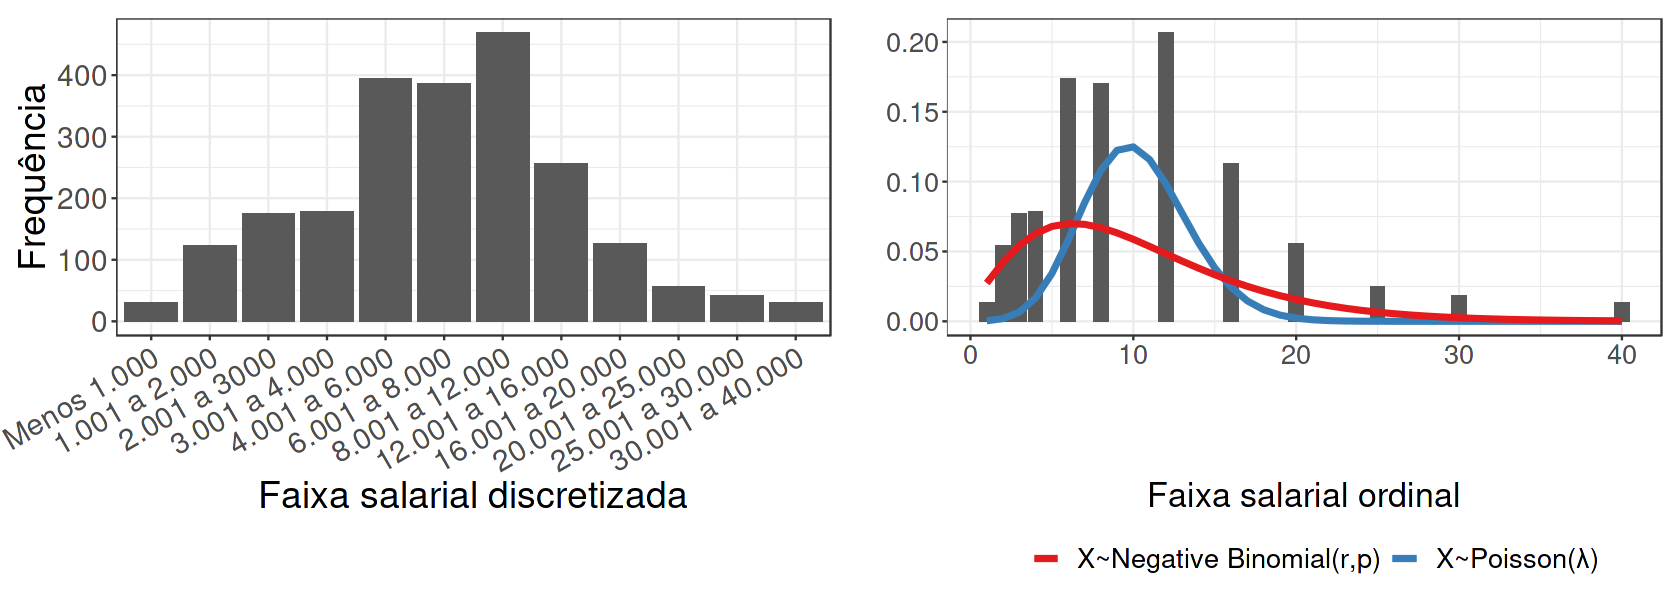

In [6]:
# Converter target para fator ordenado e para ordinal respeitando as faixas de salarios
df <- df %>% 
    mutate(p2_h_faixa_salarial = factor(p2_h_faixa_salarial,
                                        levels = c("Menos de R$ 1.000/mês",
                                                   "de R$ 1.001/mês a R$ 2.000/mês",
                                                   "de R$ 2.001/mês a R$ 3000/mês",
                                                   "de R$ 3.001/mês a R$ 4.000/mês",
                                                   "de R$ 4.001/mês a R$ 6.000/mês",
                                                   "de R$ 6.001/mês a R$ 8.000/mês",
                                                   "de R$ 8.001/mês a R$ 12.000/mês",
                                                   "de R$ 12.001/mês a R$ 16.000/mês",
                                                   "de R$ 16.001/mês a R$ 20.000/mês",
                                                   "de R$ 20.001/mês a R$ 25.000/mês",
                                                   "de R$ 25.001/mês a R$ 30.000/mês",
                                                   "de R$ 30.001/mês a R$ 40.000/mês"))) %>%
    mutate(p2_h_faixa_salarial_2 = case_when(
           p2_h_faixa_salarial == "Menos de R$ 1.000/mês"~1,
           p2_h_faixa_salarial == "de R$ 1.001/mês a R$ 2.000/mês"~2,
           p2_h_faixa_salarial == "de R$ 2.001/mês a R$ 3000/mês"~3,
           p2_h_faixa_salarial == "de R$ 3.001/mês a R$ 4.000/mês"~4,
           p2_h_faixa_salarial == "de R$ 4.001/mês a R$ 6.000/mês"~6,
           p2_h_faixa_salarial == "de R$ 6.001/mês a R$ 8.000/mês"~8,
           p2_h_faixa_salarial == "de R$ 8.001/mês a R$ 12.000/mês"~12,
           p2_h_faixa_salarial == "de R$ 12.001/mês a R$ 16.000/mês"~16,
           p2_h_faixa_salarial == "de R$ 16.001/mês a R$ 20.000/mês"~20,
           p2_h_faixa_salarial == "de R$ 20.001/mês a R$ 25.000/mês"~25,
           p2_h_faixa_salarial == "de R$ 25.001/mês a R$ 30.000/mês"~30,
           p2_h_faixa_salarial == "de R$ 30.001/mês a R$ 40.000/mês"~40,
           #p2_h_faixa_salarial == "Acima de R$ 40.001/mês" ~ 50  #repensar
))

fig(14, 5)

p1 <- df  %>% 
    mutate(p2_h_faixa_salarial = str_remove_all(p2_h_faixa_salarial, "de |/mês|R\\$ "))%>%
    mutate(p2_h_faixa_salarial = factor(p2_h_faixa_salarial, levels = c("Menos 1.000",
                                                                        "1.001 a 2.000",
                                                                        "2.001 a 3000",
                                                                        "3.001 a 4.000",
                                                                        "4.001 a 6.000",
                                                                        "6.001 a 8.000",
                                                                        "8.001 a 12.000",
                                                                        "12.001 a 16.000",
                                                                        "16.001 a 20.000",
                                                                        "20.001 a 25.000",
                                                                        "25.001 a 30.000",
                                                                        "30.001 a 40.000")))%>%
    count(p2_h_faixa_salarial) %>%
    ggplot(aes(x = p2_h_faixa_salarial, y = n))+
    geom_bar(stat='identity')+ 
    theme(axis.text.x = element_text(angle = 30, hjust=1))+
    labs(x="Faixa salarial discretizada", y = "Frequência")

p2 <- df %>%
    ggplot(aes(p2_h_faixa_salarial_2)) +
    geom_bar(aes(y = after_stat(prop)), position = "identity") +
    ggh4x::stat_theodensity(distri = "pois", aes(colour="X~Poisson(λ)"), size=1.5)+
    ggh4x::stat_theodensity(distri = "nbinom", aes(colour="X~Negative Binomial(r,p)"), size=1.5)+
    labs(x="Faixa salarial ordinal", y = "")+
    theme(legend.position='bottom', legend.title=element_blank()) +
    scale_color_brewer(palette="Set1")+
    theme(text = element_text(size=20))

p1 | p2

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Faz sentido não seguir uma distribuição Gaussiana pois a distribuição de salário não é simétrica. (Sabemos que a maioria da riquesa enta concentrada nas mãos de poucas pessoas (Bom e velho pareto))</div>
<div style="color: rgb(0, 0, 0);">→ Interessante notar que o primeiro gráfico dá impressão que a maioria dos cientistas de dados está ganhando salários na faixa de 8.000 à 12.000 reais quando na verdade, existe uma densidade maior de dados na faixa abaixo dos 10.000;</div>
<div style="color: rgb(0, 0, 0);">→ A linha vermelha da estimativa da distribuição Binomial Negativa marginal parece ter aderido melhor que a Poisson aos dados.</div>
</div>

# Compreensão das features elegíveis
---

Não me estenderei na análise exploratória pois o [relatório completo fornecido pela comunidade DataHacker](https://www.stateofdata.com.br/_files/ugd/e99c65_97b434ed9f1b40bdb3312fccc8cb8bd7.pdf) é bastante detalhado e já foi amplamente divulgado para todo o Brasil. 

Como o objetivo aqui não é o ter o modelo com a melhor previsão possível, mas sim um descritivo, focarei em mais em **remover** features com baixa consistência do que investir tempo em *feature engineering* ou *pipelines* de dados muito longos.

Com certeza existem features que poderiam ser mais exploradas e até mesmo testadas com diversos algoritmos (como feito neste [notebook](https://www.kaggle.com/code/gomes555/porto-seguro-sweetviz-sele-o-de-features) que fiz no [Porto Seguro Data Challenge](https://www.kaggle.com/competitions/porto-seguro-data-challenge/)).

In [7]:
# selecionar features elegiveis para o modelo
df <- df %>% 
  select(target = p2_h_faixa_salarial_2,
         p1_e_estado_onde_mora,
         p1_h_nivel_de_ensino,
         p1_i_area_de_formacao,
         p2_a_qual_sua_situacao_atual_de_trabalho,
         p2_b_setor,
         p2_c_numero_de_funcionarios,
         p2_d_gestor,
         p2_e_cargo_como_gestor,
         #p2_f_cargo_atual,
         p2_g_nivel,
         p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem,
         p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados,
         p2_k_voce_esta_satisfeito_na_sua_empresa_atual,
         p2_l_qual_o_principal_motivo_da_sua_insatisfacao_com_a_empresa_atual,
         p2_r_qual_a_forma_de_trabalho_ideal_para_voce,
         p3_a_qual_o_numero_aproximado_de_pessoas_que_atuam_com_dados_na_sua_empresa_hoje,
         p3_b_quais_desses_papeis_cargos_fazem_parte_do_time_ou_chapter_de_dados_da_sua_empresa,
         p4_a_atuacao,
         p4_b_quais_das_fontes_de_dados_listadas_voce_ja_analisou_ou_processou_no_trabalho,
         p4_d_quais_das_linguagens_listadas_abaixo_voce_utiliza_no_trabalho,
         p4_f_quais_dos_bancos_de_dados_fontes_de_dados_listados_abaixo_voce_utiliza_no_trabalho,
         p4_g_quais_das_opcoes_de_cloud_listadas_abaixo_voce_utiliza_no_trabalho,
         p4_h_quais_as_ferramentas_de_business_intelligence_voce_utiliza_no_trabalho,
         p6_a_quais_das_opcoes_abaixo_fazem_parte_da_sua_rotina_no_trabalho_atual_como_engenheiro_de_dados,
         p6_b_quais_as_ferramentas_tecnologias_de_etl_que_voce_utiliza_no_trabalho_como_data_engineer,
         p6_c_sua_organizacao_possui_um_data_lake,
         p6_d_qual_tecnologia_utilizada_como_plataforma_do_data_lake,
         p6_e_sua_organizacao_possui_um_data_warehouse,
         p6_f_qual_tecnologia_utilizada_como_plataforma_do_data_warehouse,
         p6_g_quais_as_ferramentas_de_gestao_de_qualidade_de_dados_metadados_e_catalogo_de_dados_voce_utiliza_no_trabalho,
         p6_h_em_qual_das_opcoes_abaixo_voce_gasta_a_maior_parte_do_seu_tempo,
         p7_a_quais_das_opcoes_abaixo_fazem_parte_da_sua_rotina_no_trabalho_atual_com_analise_de_dados,
         p7_b_quais_as_ferramentas_tecnologias_de_etl_que_voce_utiliza_no_trabalho_como_data_analyst,
         p7_c_sua_empresa_utiliza_alguma_das_ferramentas_listadas_para_dar_mais_autonomia_em_analise_de_dados_para_as_areas_de_negocio,
         p7_d_em_qual_das_opcoes_abaixo_voce_gasta_a_maior_parte_do_seu_tempo_de_trabalho,
         p8_a_quais_das_opcoes_abaixo_fazem_parte_da_sua_rotina_no_trabalho_atual_com_ciencia_de_dados,
         p8_b_quais_as_tecnicas_e_metodos_listados_abaixo_voce_costuma_utilizar_no_trabalho,
         p8_c_quais_dessas_tecnologias_fazem_parte_do_seu_dia_a_dia_como_cientista_de_dados,
         p8_d_em_qual_das_opcoes_abaixo_voce_gasta_a_maior_parte_do_seu_tempo_no_trabalho,
          )

## Estrutura geral da base

Vejamos qual o "formato" e "textura" desse dataset:

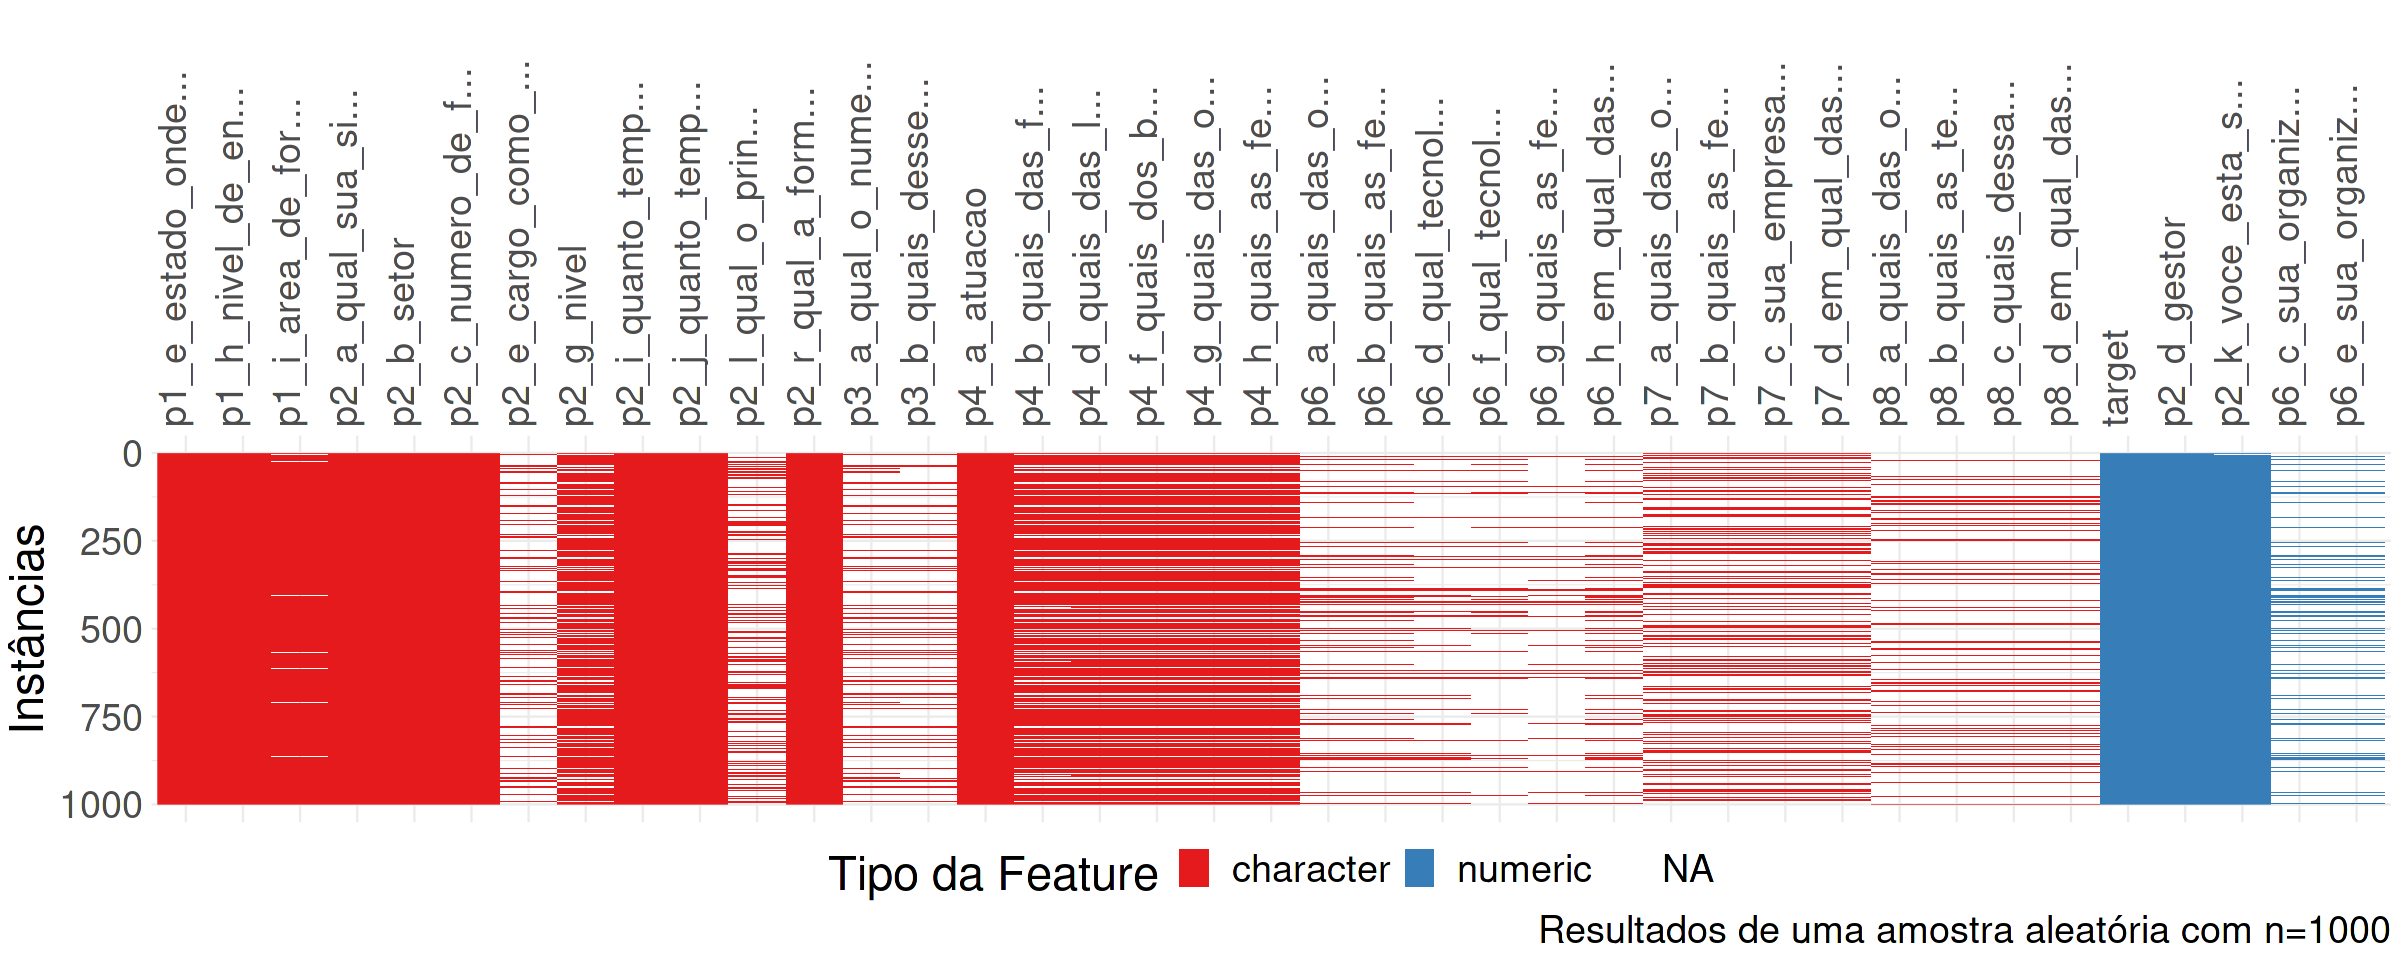

In [8]:
fig(20, 8)

df %>% 
    `colnames<-`(colnames(.) %>% map_chr(~ifelse(str_length(.x)>16, str_sub(.x, end=16) %>% paste0("..."), .x))) %>%
    sample_n(1000) %>% 
    visdat::vis_dat() + 
    theme(text = element_text(size=28), legend.position='bottom')+
    #coord_flip()+
    labs(caption="Resultados de uma amostra aleatória com n=1000", y="Instâncias") +
    guides(fill=guide_legend(title="Tipo da Feature"))+
    scale_fill_brewer(palette="Set1")+ 
    theme(axis.text.x = element_text(angle = 90, vjust=1))

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Maioria das features são categóricas de respostas multivaloradas:</div>
<div style="color: rgb(0, 0, 0);">→ 5% das features estão totalmente *missing*;</div>
<div style="color: rgb(0, 0, 0);">→ ~40% da base é composta por dados missing, o que pode exigir algum cuidado em termos de modelagem;</div>
<div style="color: rgb(0, 0, 0);">→ Ocorre um padrão de dados <i>missing</i> em várias features simultâneamente para pessoas que não informaram o cargo (Essas perguntas não foram mostradas).</div>
</div>

## Estudar de missing value

Procurando entender mais a fundo como é a distribuição destes dados *missing*:

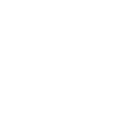

In [9]:
fig(1, 1) # Precisei desta celula apenas para armazenar os resultados sem alterar o nome das colunas
res <- df %>% 
    DataExplorer::plot_missing(missing_only = T, 
                               ggtheme = theme_bw(),
                               geom_label_args = list(size=7, hjust='inward'),
                               theme_config = list(text = element_text(size=28),
                                                   legend.position='bottom'))

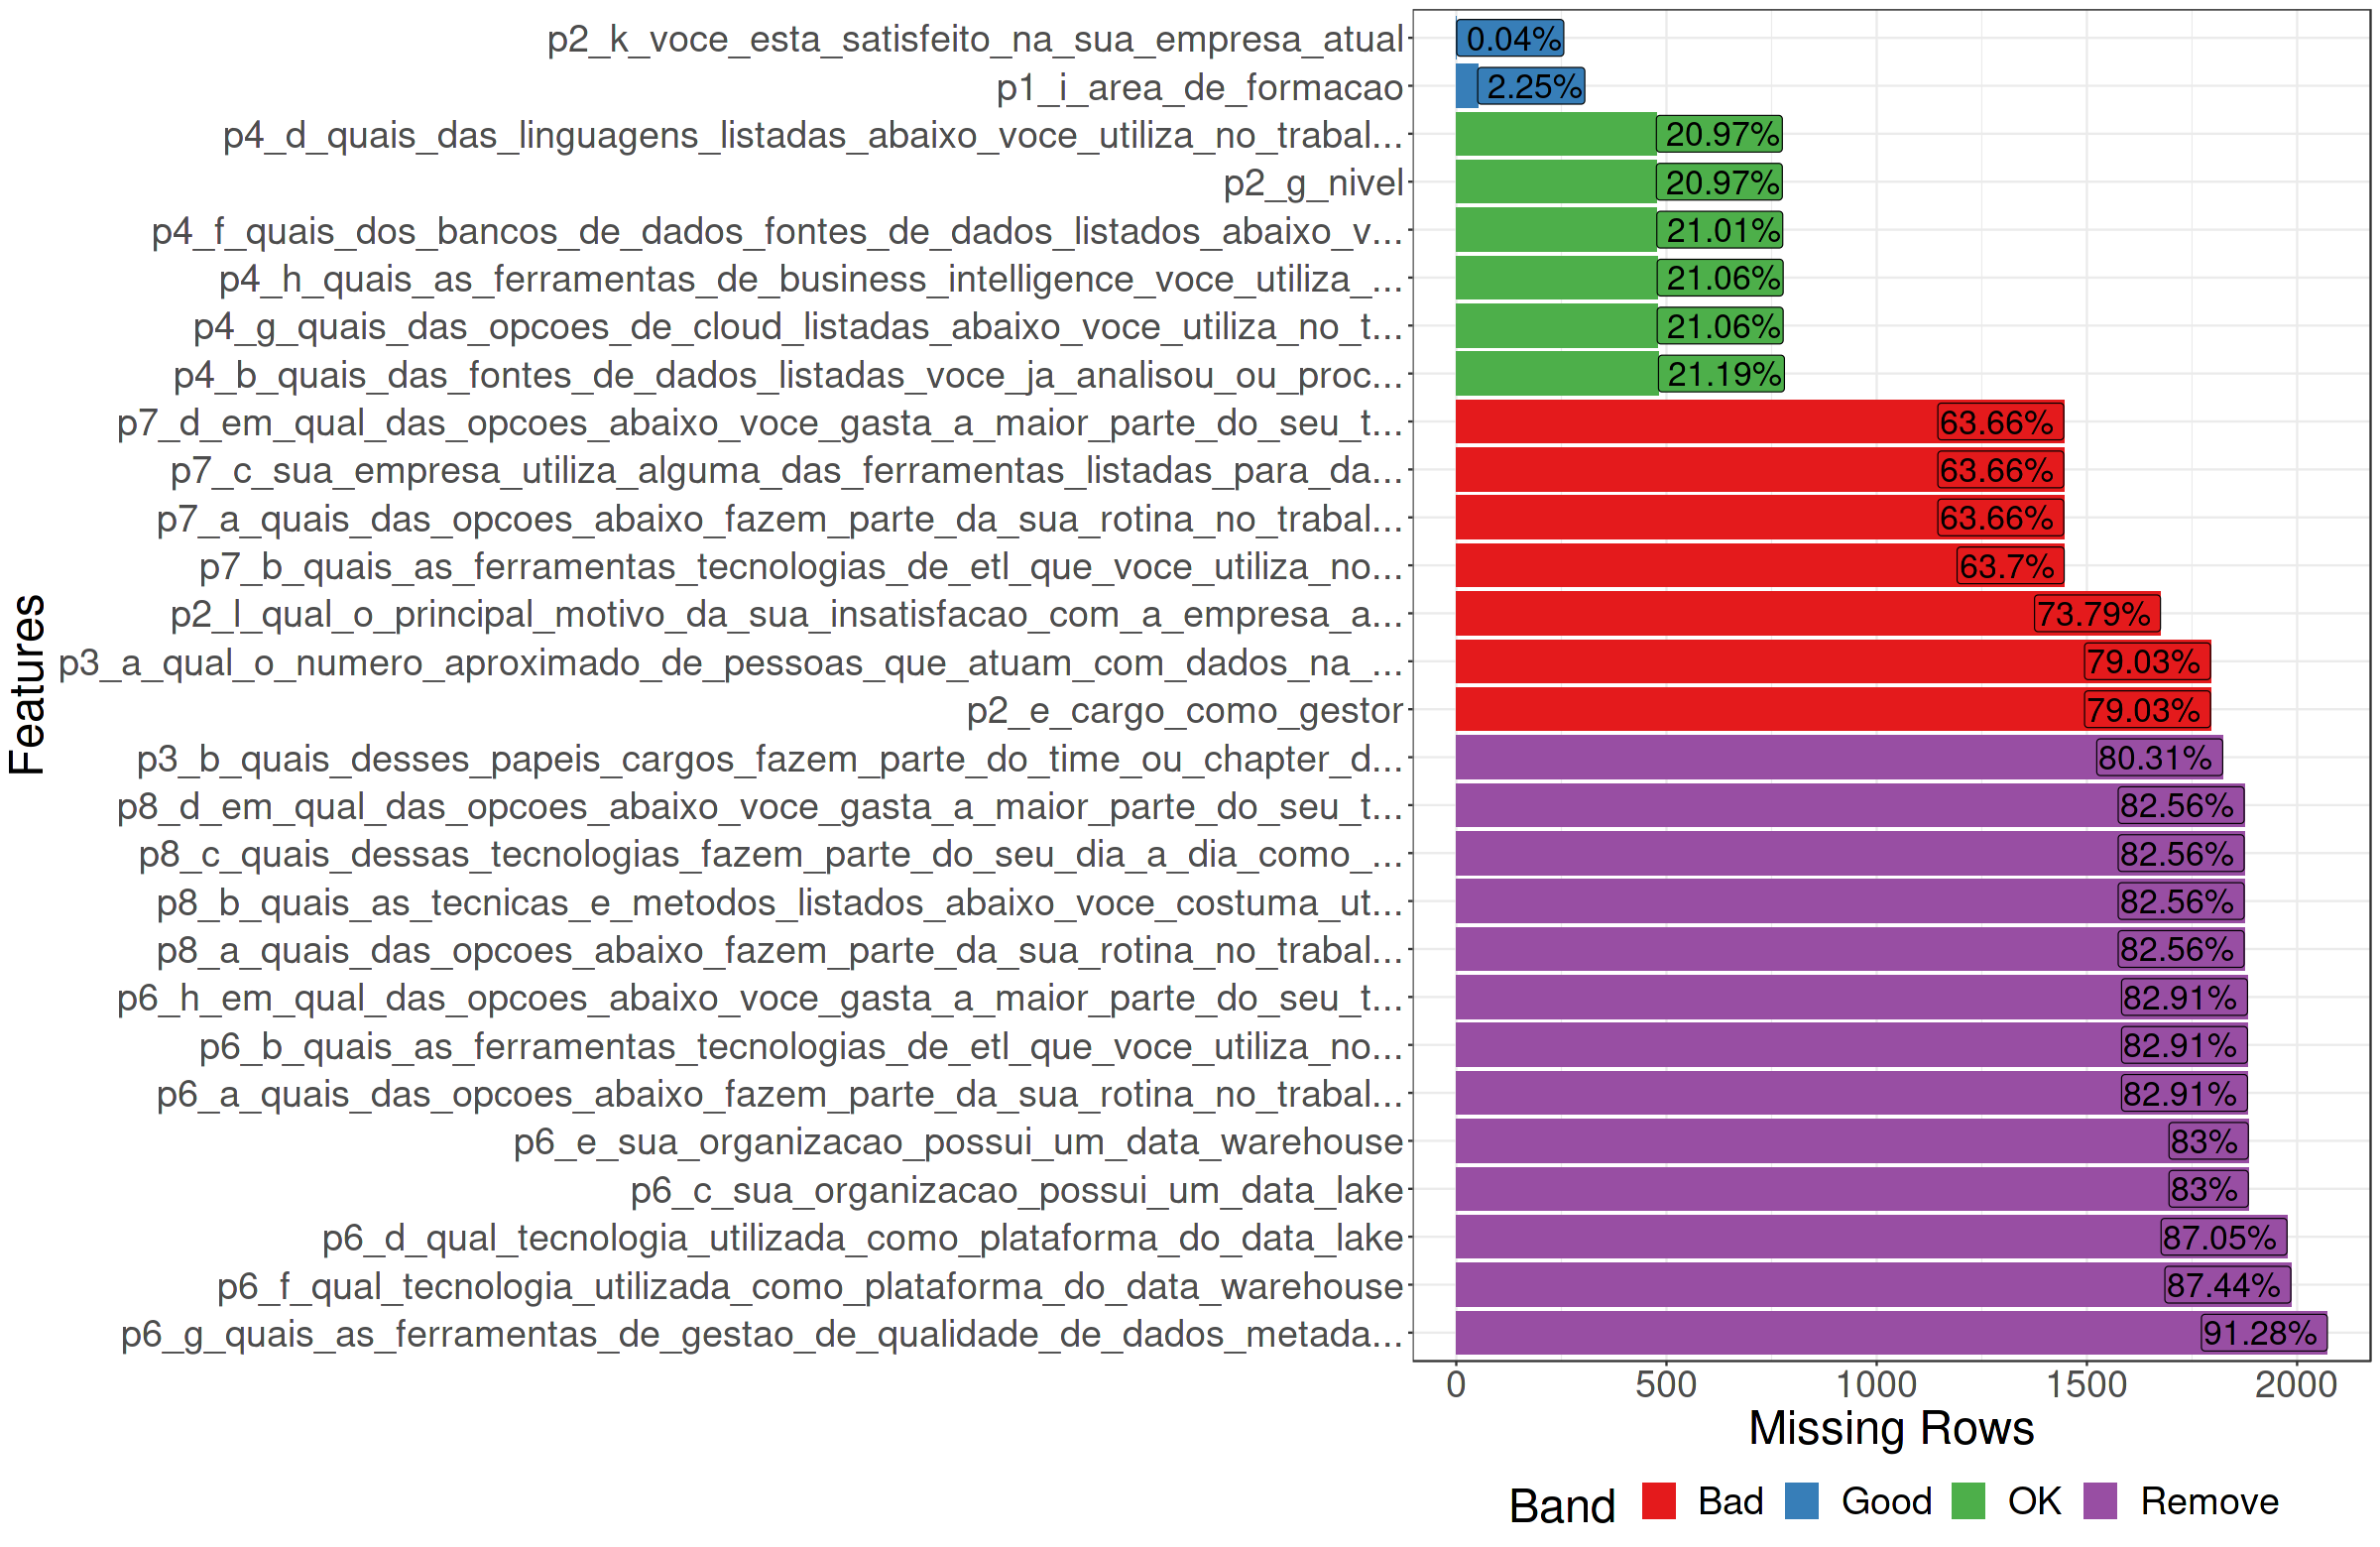

In [10]:
fig(20, 13)

# alterar o codigo fonte da funcao para alterar a cor do grafico
plot_missing_2 <- function (data, group = list(Good = 0.05, OK = 0.4, Bad = 0.8, 
  Remove = 1), missing_only = FALSE, geom_label_args = list(), 
  title = NULL, ggtheme = theme_gray(), theme_config = list(legend.position = c("bottom"))) 
{
  num_missing <- pct_missing <- Band <- NULL
  missing_value <- data.table::data.table(DataExplorer::profile_missing(data))
  if (missing_only) 
    missing_value <- missing_value[num_missing > 0]
  group <- group[sort.list(unlist(group))]
  invisible(lapply(seq_along(group), function(i) {
    if (i == 1) {
      missing_value[pct_missing <= group[[i]], `:=`(Band, 
        names(group)[i])]
    } else {
      missing_value[pct_missing > group[[i - 1]] & pct_missing <= 
        group[[i]], `:=`(Band, names(group)[i])]
    }
  }))
  output <- ggplot(missing_value, aes_string(x = "feature", 
    y = "num_missing", fill = "Band")) + geom_bar(stat = "identity") + coord_flip() + xlab("Features") + 
    ylab("Missing Rows") + guides(fill = guide_legend(override.aes = aes(label = "")))+
    scale_fill_brewer(palette="Set1")
  geom_label_args_list <- list(mapping = aes(label = paste0(round(100 * 
    pct_missing, 2), "%")))
  output <- output + do.call("geom_label", c(geom_label_args_list, 
    geom_label_args))
  class(output) <- c("single", class(output))
  DataExplorer::plotDataExplorer(plot_obj = output, title = title, ggtheme = ggtheme, 
    theme_config = theme_config)
}

df %>% 
    `colnames<-`(colnames(.) %>% map_chr(~ifelse(str_length(.x)>64, str_sub(.x, end=64) %>% paste0("..."), .x))) %>%
    plot_missing_2(missing_only = T, 
                               ggtheme = theme_bw(),
                               geom_label_args = list(size=7, hjust='inward'),
                               theme_config = list(text = element_text(size=28),
                                                   legend.position='bottom'))

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Muitas das features com muitos dados missing estão relacionados com o tipo de Data lake ou Data Warehouse bem como perguntas específicas para engenheiros de dados;</div>
    
<div style="color: rgb(0, 0, 0);">→ A elevada quantidade de missing ocorre pois muitos funcionários não viras essas respostas que estão mais relacionadas com a área de engenharia de dados, que tem baixa porcentagem (~13%) de respondentes no questionário.
</div>

In [11]:
#identificar features que serao removidas 
to_drop <- res$data %>% filter(pct_missing>.25) %>% pull(feature)

# identificar que serao utilizadas na modelagem
to_keep <- colnames(df)[!colnames(df) %in% to_drop]

# Pipeline de dados
---

Depois de toda as análises e interações, o seguinte pipeline de dados foi implementado:

<div class="alert alert-success"> 
<strong><div style="color: rgb(0, 0, 0);">🔧  Pipeline de dados(*):</div></strong> <br>

<div style="color: rgb(0, 0, 0);">│   Dados brutos;</div> 
<div style="color: rgb(0, 0, 0);">├─ Reter apenas features que não tragam algum viés ao modelo;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover instâncias de quem não informou o salário;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover instâncias de quem informou salário superior à 40.000;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover quem mora fora do Brasil;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover quem trabalha para empresa fora do Brasil;</div> 
<div style="color: rgb(0, 0, 0);">├─ Converter faixa salarial para numérico ordinal;</div> 
<div style="color: rgb(0, 0, 0);">├─ Selecionar dummys das features de respostas multivaloradas;</div> 
<div style="color: rgb(0, 0, 0);">├─ Converter <i>nível profissional, nível de ensino, número de funcionários na empresa atual, tempo de experiência com dados, tempo de experiência com ti</i> para ordinal;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover estagiários;</div> 
<div style="color: rgb(0, 0, 0);">├─ Padronizar trabalho ideal;</div> 
<div style="color: rgb(0, 0, 0);">├─ Reter instâncias com menos do que 25% de dados missing;</div> 
<div style="color: rgb(0, 0, 0);">├─ Em seguida, dropar instâncias que apresentam *missing value* em diversas features simultâneamente pois parece muitos indivíduos não viram essas perguntas multi-objetivo;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover features com 99% de valores igual a zero;</div> 
<div style="color: rgb(0, 0, 0);">├─ Remover features com marcação para <i>outros</i>;</div> 
<div style="color: rgb(0, 0, 0);">└─ Base analítica.</div> 
    
(*) Não precisa ser necessariamente nesta ordem
 


In [12]:
# preparar base analitica
df <- df_full %>%
    filter((!is.na(p2_h_faixa_salarial)) & 
           (p2_h_faixa_salarial != "Acima de R$ 40.001/mês") & 
           (p1_e_b_regiao_onde_mora!='Fora do Brasil') & 
           (!p2_a_qual_sua_situacao_atual_de_trabalho %in% c('Vivo fora do Brasil e trabalho para empresa de fora do Brasil', 
                                                             'Vivo no Brasil e trabalho remoto para empresa de fora do Brasil (PJ)')))%>%
    mutate(target = case_when(
      p2_h_faixa_salarial == "Menos de R$ 1.000/mês"~1,
      p2_h_faixa_salarial == "de R$ 1.001/mês a R$ 2.000/mês"~2,
      p2_h_faixa_salarial == "de R$ 2.001/mês a R$ 3000/mês"~3,
      p2_h_faixa_salarial == "de R$ 3.001/mês a R$ 4.000/mês"~4,
      p2_h_faixa_salarial == "de R$ 4.001/mês a R$ 6.000/mês"~6,
      p2_h_faixa_salarial == "de R$ 6.001/mês a R$ 8.000/mês"~8,
      p2_h_faixa_salarial == "de R$ 8.001/mês a R$ 12.000/mês"~12,
      p2_h_faixa_salarial == "de R$ 12.001/mês a R$ 16.000/mês"~16,
      p2_h_faixa_salarial == "de R$ 16.001/mês a R$ 20.000/mês"~20,
      p2_h_faixa_salarial == "de R$ 20.001/mês a R$ 25.000/mês"~25,
      p2_h_faixa_salarial == "de R$ 25.001/mês a R$ 30.000/mês"~30,
      p2_h_faixa_salarial == "de R$ 30.001/mês a R$ 40.000/mês"~40,
      #p2_h_faixa_salarial == "Acima de R$ 40.001/mês" ~ 50  #repensar
    ))%>% 
    select(target, starts_with(str_replace_all(to_keep, "(p\\d_\\w_)\\S+", "\\1") %>% unique())) %>%
    select(-p1_e_a_uf_onde_mora, 
           -p1_e_b_regiao_onde_mora, 
           -p4_a_a_mesmo_que_esse_nao_seja_seu_cargo_formal_voce_considera_que_sua_atuacao_no_dia_a_dia_reflete_alguma_das_opcoes_listadas_abaixo,
           -p4_b_quais_das_fontes_de_dados_listadas_voce_ja_analisou_ou_processou_no_trabalho,
           -p4_d_quais_das_linguagens_listadas_abaixo_voce_utiliza_no_trabalho,
           -p4_f_quais_dos_bancos_de_dados_fontes_de_dados_listados_abaixo_voce_utiliza_no_trabalho,
           -p4_g_quais_das_opcoes_de_cloud_listadas_abaixo_voce_utiliza_no_trabalho,
           -p4_h_quais_as_ferramentas_de_business_intelligence_voce_utiliza_no_trabalho,
          ) %>%
    mutate(p2_g_nivel = case_when(
        p2_g_nivel=='Júnior'~1,
        p2_g_nivel=='Pleno'~2,
        p2_g_nivel=='Sênior'~3
    )) %>%
    mutate(p1_h_nivel_de_ensino = case_when(
        p1_h_nivel_de_ensino == 'Estudante de Graduação'~1,
        p1_h_nivel_de_ensino == 'Graduação/Bacharelado'~2,
        p1_h_nivel_de_ensino == 'Mestrado'~3,
        p1_h_nivel_de_ensino == 'Pós-graduação'~3,
        p1_h_nivel_de_ensino == 'Doutorado ou Phd'~4
    )) %>%
    mutate(p2_c_numero_de_funcionarios = case_when(
        p2_c_numero_de_funcionarios=="de 1 a 5"~1,
        p2_c_numero_de_funcionarios=="de 6 a 10"~2,
        p2_c_numero_de_funcionarios=="de 11 a 50"~3,
        p2_c_numero_de_funcionarios=="de 51 a 100"~4,
        p2_c_numero_de_funcionarios=="de 101 a 500"~5,
        p2_c_numero_de_funcionarios=="de 501 a 1000"~6,
        p2_c_numero_de_funcionarios=="de 1001 a 3000"~7,
        p2_c_numero_de_funcionarios=="Acima de 3000"~8,
    )) %>%
    mutate(p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem = case_when(
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="Não tenho experiência na área de dados"~0, 
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="Menos de 1 ano"~1,
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="de 1 a 2 anos"~2, 
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="de 2 a 3 anos"~3, 
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="de 4 a 5 anos"~4,
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="de 6 a 10 anos"~5,
        p2_i_quanto_tempo_de_experiencia_na_area_de_dados_voce_tem=="Mais de 10 anos"~6
    )) %>%
    mutate(p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados = case_when(
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="Não tive experiência na área de TI/Engenharia de Software antes de começar a trabalhar na área de dados"~0, 
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="Menos de 1 ano"~1,
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="de 1 a 2 anos"~2, 
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="de 2 a 3 anos"~3, 
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="de 4 a 5 anos"~4,
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="de 6 a 10 anos"~5,
        p2_j_quanto_tempo_de_experiencia_na_area_de_ti_engenharia_de_software_voce_teve_antes_de_comecar_a_trabalhar_na_area_de_dados=="Mais de 10 anos"~6
    )) %>% 
    mutate(p2_r_qual_a_forma_de_trabalho_ideal_para_voce = case_when(
        p2_r_qual_a_forma_de_trabalho_ideal_para_voce=="Modelo 100% presencial"~"presencial",
        p2_r_qual_a_forma_de_trabalho_ideal_para_voce=="Modelo 100% remoto"~"remoto",
        p2_r_qual_a_forma_de_trabalho_ideal_para_voce=="Modelo híbrido flexível (o funcionário tem liberdade para escolher quando estar no escritório presencialmente)"~"Híbrido",
        p2_r_qual_a_forma_de_trabalho_ideal_para_voce=="Modelo híbrido com dias fixos de trabalho presencial"~"Híbrido",
        TRUE~p2_r_qual_a_forma_de_trabalho_ideal_para_voce
    )) %>%
    na.omit() %>%
    filter(p2_a_qual_sua_situacao_atual_de_trabalho != "Estagiário")

# converter situacao atual de trabalho para dummy
df <- df %>% 
rename(p2_a_situacao = p2_a_qual_sua_situacao_atual_de_trabalho) %>%
  sjmisc::to_dummy(p2_a_situacao, var.name = "", suffix = "label") %>% 
  bind_cols(df %>% select(-p2_a_qual_sua_situacao_atual_de_trabalho))

# converter setor para dummy
df <- df %>% 
  sjmisc::to_dummy(p2_b_setor, var.name = "", suffix = "label") %>% 
  bind_cols(df %>% select(-p2_b_setor))

# converter estado para dummy
df <- df %>% 
  sjmisc::to_dummy(p1_e_estado_onde_mora, var.name = "", suffix = "label") %>% 
  bind_cols(df %>% select(-p1_e_estado_onde_mora))

# converter area de formacao para dummy
df <- df %>% 
  sjmisc::to_dummy(p1_i_area_de_formacao, var.name = "", suffix = "label") %>% 
  bind_cols(df %>% select(-p1_i_area_de_formacao))

# converter atuacao para dummy
df <- df %>% 
  sjmisc::to_dummy(p4_a_atuacao, var.name = "", suffix = "label") %>% 
  bind_cols(df %>% select(-p4_a_atuacao))

# converter forma de trabalho preferida para dummy
df <- df %>% 
  rename(p2_r_forma_de_trabalho = p2_r_qual_a_forma_de_trabalho_ideal_para_voce) %>%
  sjmisc::to_dummy(p2_r_forma_de_trabalho, var.name = "", suffix = "label") %>% 
  bind_cols(df %>% select(-p2_r_qual_a_forma_de_trabalho_ideal_para_voce))

# remover features com mais de 99% zeros
to_drop <- names(map_dbl(df, ~sum(.x==0, na.rm=T)/nrow(df)) %>% .[.>.99])
df <- df %>% dplyr::select(-one_of(to_drop))

# Arrumar nome apos criacao de dummys
df <- df %>% janitor::clean_names()

# remover features de marcacao para "outros"
df <- df %>% select(-p4_a_atuacao_outra,
                    -p1_i_area_de_formacao_outras,
                    -p2_b_setor_outro,
                    -p4_d_n_nao_utilizo_nenhuma_linguagem,
                    -p4_h_p_looker)

# cortar nomes para sumario do modelo
to_model <- `colnames<-`(df, colnames(df) %>% str_sub(end=32))

Vamos perguntar ao nosso robozinho como está nosso dataset analítico:

 > 💬 SmartPay, qual status geral da base analítica?

In [13]:
print(glue::glue("
   .________________________________________________________.
   |A base analítica possui agora {nrow(df)} linhas, {ncol(df)} colunas. |
   |Destas features, {length(df%>%map_dbl(~sum(!.x%in%c(0, 1)))%>% .[.==0])} correspondem a dummys.             |
   |O que torna a base analítica bastante esparsa!          |
   |________________________________________________________.
🤖 v"))

   .________________________________________________________.
   |A base analítica possui agora 1601 linhas, 126 colunas. |
   |Destas features, 120 correspondem a dummys.             |
   |O que torna a base analítica bastante esparsa!          |
   |________________________________________________________.
🤖 v


# Modelagem
---

Uma coisa é certa: a média salarial engana. 

Simplesmente tirar a média de salários (ou ajustar modelos supondo distribuição normal) por profissões pode ser enganoso, já que não são eventos independentes pois diversas variáveis influenciam e ainda ocorre na sociedade em geral, que 20% das pessoas acumulam 80% de toda a riqueza (bom e velho pareto) e isso não deve ser diferente com os salários dos cientistas de dados. 

Para modelagem utilizarei a biblioteca `gamlss` (modelos aditivos generalizados para localização, escala e forma) que cobre algumas limitações de modelos estatísticos como GLM e GAM.

Da documentação:

> "Modelos aditivos generalizados para localização, escala e forma (GAMLSS) são modelos do tipo de regressão semi-paramétrica. parâmetros da distribuição, como funções de variáveis explicativas, podem envolver o uso de funções de suavização não paramétricas"

Assim, a forma de distribuição assumida para a variável resposta $Y,f_Y(y|µ,σ,ν,τ)$, pode ser muito geral

Boa referência para usar a biblioteca: https://www.gamlss.com/wp-content/uploads/2013/01/book-2010-Athens1.pdf

## Detecção de outliers 🔪

Depois e muitas interações na etapa de modelagem, notei a presença de alguns outliers bastante atípicos, como uma respondente, que informou ser *Analista de Dados/Data Analyst* com nivel *Júnior* no *Setor Público* mas sua faixa salarial vai de R\\$ 30.001 a R\$ 40.000 por mês. Se isso não foi um erro é realmente impressionante! 💸 

A fim de diminuir um pouco os resíduos do modelo, ajustei um modelo `glm.nb` (*Negative Binomial Generalized Linear Model*) para calcular as distâncias de Cook (pois os outliers estavam aparecendo em praticament e todas as interações) e descartar os 20 *outliers* com esses valores mais altos.

**Obs.:** O `gamlss` estava demorando muito para calcular as distâncias de Cook pois o resíduo não era Normal, então não tem atalho de achar os betas usando algebra. Provavelmente estava estimando N modelos excluindo cada uma das observações.

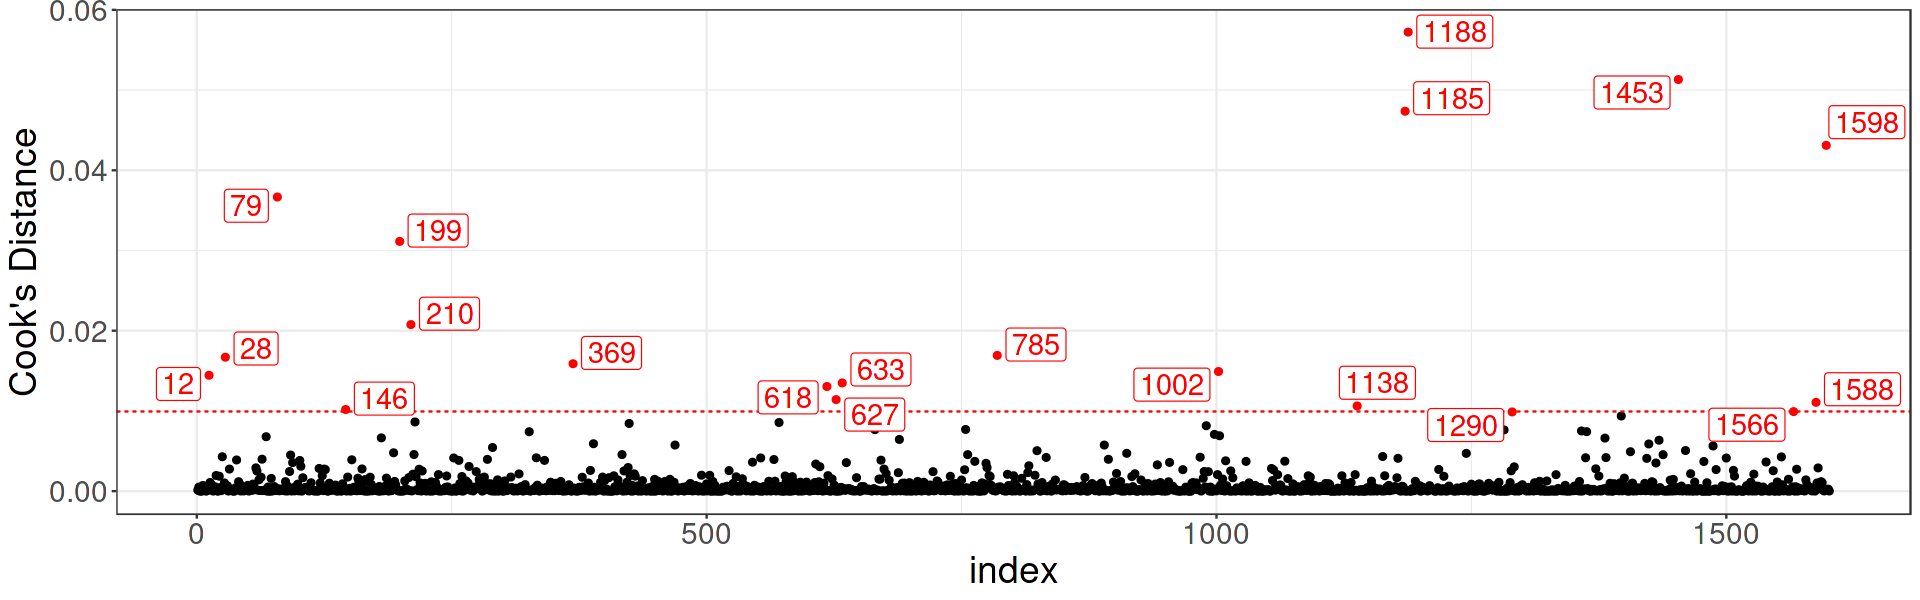

In [14]:
fig(16, 5)

# ajustar um glm negative binom
m <- glm.nb(target~., data=to_model)

# calcular cook's distance com glm:
cooksd <- cooks.distance(m)

# numero de outliers para detectar
n_out <- 20 

# arrumar informacao da distancia de cook
cooksd <- tibble(id = 1:length(cooksd),
                 cooksd = cooksd) %>%
            mutate(out = ifelse(cooksd>=min(tail(sort(abs(cooksd)),n_out)), T, F),
                   lab = ifelse(out, id, NA_character_))

# gerar grafico
cooksd %>%
    ggplot(aes(x=id, y=cooksd, colour=out), alpha=0.7)+
    geom_point()+
    geom_hline(yintercept=cooksd %>% filter(!is.na(lab)) %>% filter(cooksd == min(cooksd)) %>% pull(cooksd),
               linetype="dashed", color = "red")+
    ggrepel::geom_label_repel(aes(label=lab), size=6)+
    scale_colour_manual(values = c("black", "red"))+
    labs(y = "Cook's Distance", x = "index")+
    theme(legend.position="none")

# dropar outliers da base
to_drop <- cooksd %>% filter(out) %>% pull(id) # p0_id = 9xbe9voeit10zxkge9xbe9h77y9r6wca
to_model <- to_model[-na.omit(to_drop),]

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ A linha tracejada vermelha marca a menor distância de Cook dentre as 20 maiores;</div>
    
<div style="color: rgb(0, 0, 0);">→ Talvez existam outras maneiras de manter alguns destes outliers e ainda assim conseguir um modelo válido.
</div>

## Ajustar modelo

Após aplicar a transformação para atribuir o valor do limite superior de cada faixa de salário, temos que os inteiros não negativos têm um "significado" de inteiro verdadeiro (ou seja, 5 representa uma quantidade cinco vezes o que 1 representa), e particularmente se eles representam chegadas em um processo, então a regressão Poisson seria uma boa distribuição para começar porém, a target apresentou um comportamento de superdispersão.

A regressão binomial negativa pode ser usada para dados de contagem superdispersos, ou seja, quando a variância condicional excede a média condicional. Pode ser considerada como uma generalização da regressão de Poisson, pois possui a mesma estrutura média da regressão de Poisson e possui um parâmetro extra para modelar a sobredispersão.

<div class="alert alert-warning"> 
<strong><div style="color: rgb(0, 0, 0);">⚠️ Considerações antes de usar este tipo de modelo: </div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Não é recomendado que modelos binomiais negativos sejam aplicados a amostras pequenas (no nosso caso a base é pequena relativo ao número de features);</div>
<div style="color: rgb(0, 0, 0);">→ Uma causa comum de superdispersão é o excesso de zeros por um processo adicional de geração de dados, o que não é o caso aqui;</div>
<div style="color: rgb(0, 0, 0);">→ Como nosso processo de geração de dados não permite nenhum 0, um modelo com zero truncado poderia ser mais apropriado;</div>
<div style="color: rgb(0, 0, 0);">→  A variável de resultado em uma regressão binomial negativa não pode ter números negativos;</div>
<div style="color: rgb(0, 0, 0);">→  Os resíduos do modelo precisam ser verificados para suposições do modelo binomial negativo com gamlss (<a href="https://fairmlbook.org/index.html">consulte aqui</a>).</div>
</div>





In [15]:
set.seed(0)

# Ajustar modelo
model<-gamlss(formula = target~.,
              family=NBI(mu.link="log"), 
              control = gamlss.control(n.cyc = 200, trace=FALSE),
              data=to_model)

In [16]:
# Testar selecao de features com stepAIC
# model<-stepGAIC(gamlss(target~., family=NBI(mu.link="log"), data= to_model),
#                    parallel = "multicore", ncpus = 4L, steps=20, trace=F)

Vejamos um resumo sobre o ajuste do modelo:

In [17]:
summary_model <- summary(model)

******************************************************************
Family:  c("NBI", "Negative Binomial type I") 

Call:  
gamlss(formula = target ~ ., family = NBI(mu.link = "log"), data = to_model,  
    control = gamlss.control(n.cyc = 200, trace = FALSE)) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.424274   0.216168   1.963 0.049870 *  
p2_r_forma_de_trabalho_hibrido   -0.029304   0.019497  -1.503 0.133054    
p2_r_forma_de_trabalho_presencia -0.171795   0.094719  -1.814 0.069924 .  
p4_a_atuacao_analise_de_dados    -0.059722   0.038781  -1.540 0.123779    
p4_a_atuacao_ciencia_de_dados     0.100099   0.041973   2.385 0.017213 *  
p4_a_atuacao_engenharia_de_dados  0.023830   0.043005   0.554 0.579580    
p1_i_area_de_formacao_ciencias_b -0.101771   0.102118  -0.997 0.319122    
p1_i_are

<div class="alert alert-success"> 
<div style="color: rgb(0, 0, 0);">✅ <b>Features consideradas no modelo:</b></div>

<div style="color: rgb(0, 0, 0);">

<ul>
  <li>Forma de trabalho (hibrido, preencial, remoto);</li>
  <li>Qual tipo de atuação;</li>
  <li>Área de Formação;</li>
  <li>Estado onde mora;</li>
  <li>Setor da empresa;</li>
  <li>Situacao (freela, clt, cnpj);</li>
  <li>Nivel de ensino;</li>
  <li>Número de funcionarios na empresa;</li>
  <li>Nível do cargo (Júnior, Pleno, Sênior);</li>
  <li>Quanto tempo de experiencia em Data Science;</li>
  <li>Quanto tempo de experiencia em TI;</li>
  <li>Esta satisfeito aonde esta? (⛳️ flag para tech recruiters que estao tentando "pescar candidatos");</li>
  <li>Quais fontes de dados ja usou;</li>
  <li>Quais fontes de dados usa a maior parte do tempo;</li>
  <li>Qual da linguagens vc usa;</li>
  <li>Quais bancos de dados usa no trabalho;</li>
  <li>Qual tipo de cloud;</li>
  <li>Qual tipo de ferramenta de BI.</li>
</ul>
    
</div>

## Diagnóstico de resíduos

Os modelos GAMLSS usam os resíduos de quantil normalizados para variáveis de resposta contínua e resíduos de quantil normalizados aleatórios para variáveis de resposta discreta. 

A principal vantagem dos resíduos quantílicos normalizados (randomizados) é que, qualquer que seja a distribuição da variável de resposta, seus valores verdadeiros sempre têm uma distribuição normal padrão, desde que as suposições do modelo estejam corretas. 

Vejamos os gráficos para análise de resíduos:

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  0.01017827 
                       variance   =  0.8469738 
               coef. of skewness  =  0.3101528 
               coef. of kurtosis  =  3.535585 
Filliben correlation coefficient  =  0.9962008 
******************************************************************


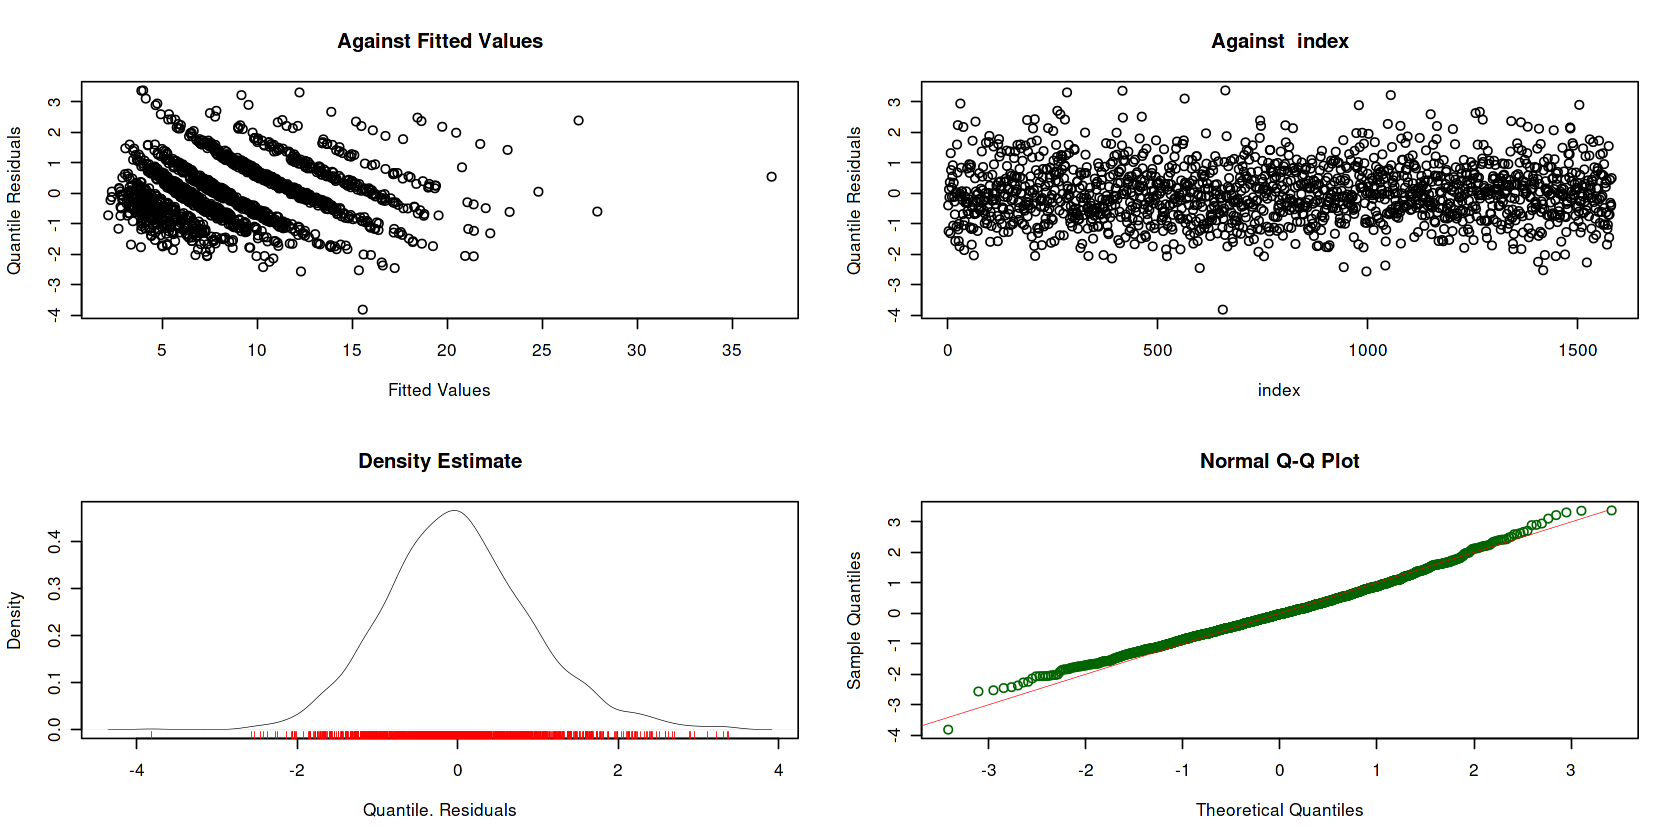

In [18]:
fig(14,7)
par(mfrow=c(2,2), col="black")
plot(model, parameters = list(color='black', col="black"))

In [19]:
#tibble(
#residuals = residuals(model, ),
#    index = 1:length(model$residuals),
#    fitted = fitted(m)
#)

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→  O gráfico de localização da escala não indica heterocedasticidade porém um modelo NB perfeitamente ajustado pode exibir resíduos de desvio não homogêneos (ainda mais com tantas dummys); </div>
<div style="color: rgb(0, 0, 0);">→  O gráfico de resíduos versus o indice sugere que os resíduos são independentes um do outro; </div>
<div style="color: rgb(0, 0, 0);">→  A densidade dos resíduos não sugere nenhuma assimetria ou presença de outliers 😬; </div>
<div style="color: rgb(0, 0, 0);">→  O QQ-plot apresentou o comportamento esperado; </div>

Teste de Kolmogorov-Smirnov para testar a normalidade dos dados:

In [20]:
ks.test(model$residuals, 'pnorm', mean(model$residuals), sd(model$residuals))


	One-sample Kolmogorov-Smirnov test

data:  model$residuals
D = 0.034049, p-value = 0.05117
alternative hypothesis: two-sided


<div class="alert alert-success"> 
<div style="color: rgb(0, 0, 0);">✅ Não há evidência estatística para rejeitar a hipótese de normalidade dos resíduos.</div>

## Coeficiente de Determinação

Vamos perguntar ao nosso robozinho como está nosso modelo:

 > 💬 SmartPay, qual status do modelo?

In [21]:
print(glue::glue("
   .______________________________________________.
   |O R² do modelo Binomial Negativo foi: {round(Rsq(model), 5)}  |
   |______________________________________________.
🤖 v"))

   .______________________________________________.
   |O R² do modelo Binomial Negativo foi: 0.6499  |
   |______________________________________________.
🤖 v


A estatística R² (*Generalised (Pseudo) R-squared*) indica que ~64% da variabilidade dos dados é captada pelo modelo. Não é tão alta mas também não é a melhor métrica para critério de seleção. É bom monitorar seu valor mas o que temos aqui é um modelo estatísticamente válido para estes dados!

# Principais resultados
---

Lembrando que nossa variável dependente é uma variável de contagem que é superdispersa, e o modelo ajusta o `log` da contagem esperada como uma função das variáveis preditoras. 

Podemos interpretar os coeficientes da [seguinte forma](https://stats.oarc.ucla.edu/stata/output/negative-binomial-regression/#:~:text=We%20can%20interpret%20the%20negative,in%20the%20model%20are%20held) (tradução livre): 

> "Para uma mudança de uma unidade na variável preditora, espera-se que a diferença nos logs das "contagens esperadas" da faixa de salário mude pelo respectivo coeficiente de regressão, dado que as outras variáveis preditoras no modelo são mantidos constantes."

Além disso, também estamos interessados em observar as <b>taxas de incidência</b> além dos coeficientes. Para fazer isso, podemos exponenciar nossos coeficientes de modelo (O mesmo se aplica aos intervalos de confiança).

Agora vejamos os valores dos coeficientes com maiores estimativas e algumas interpretações:



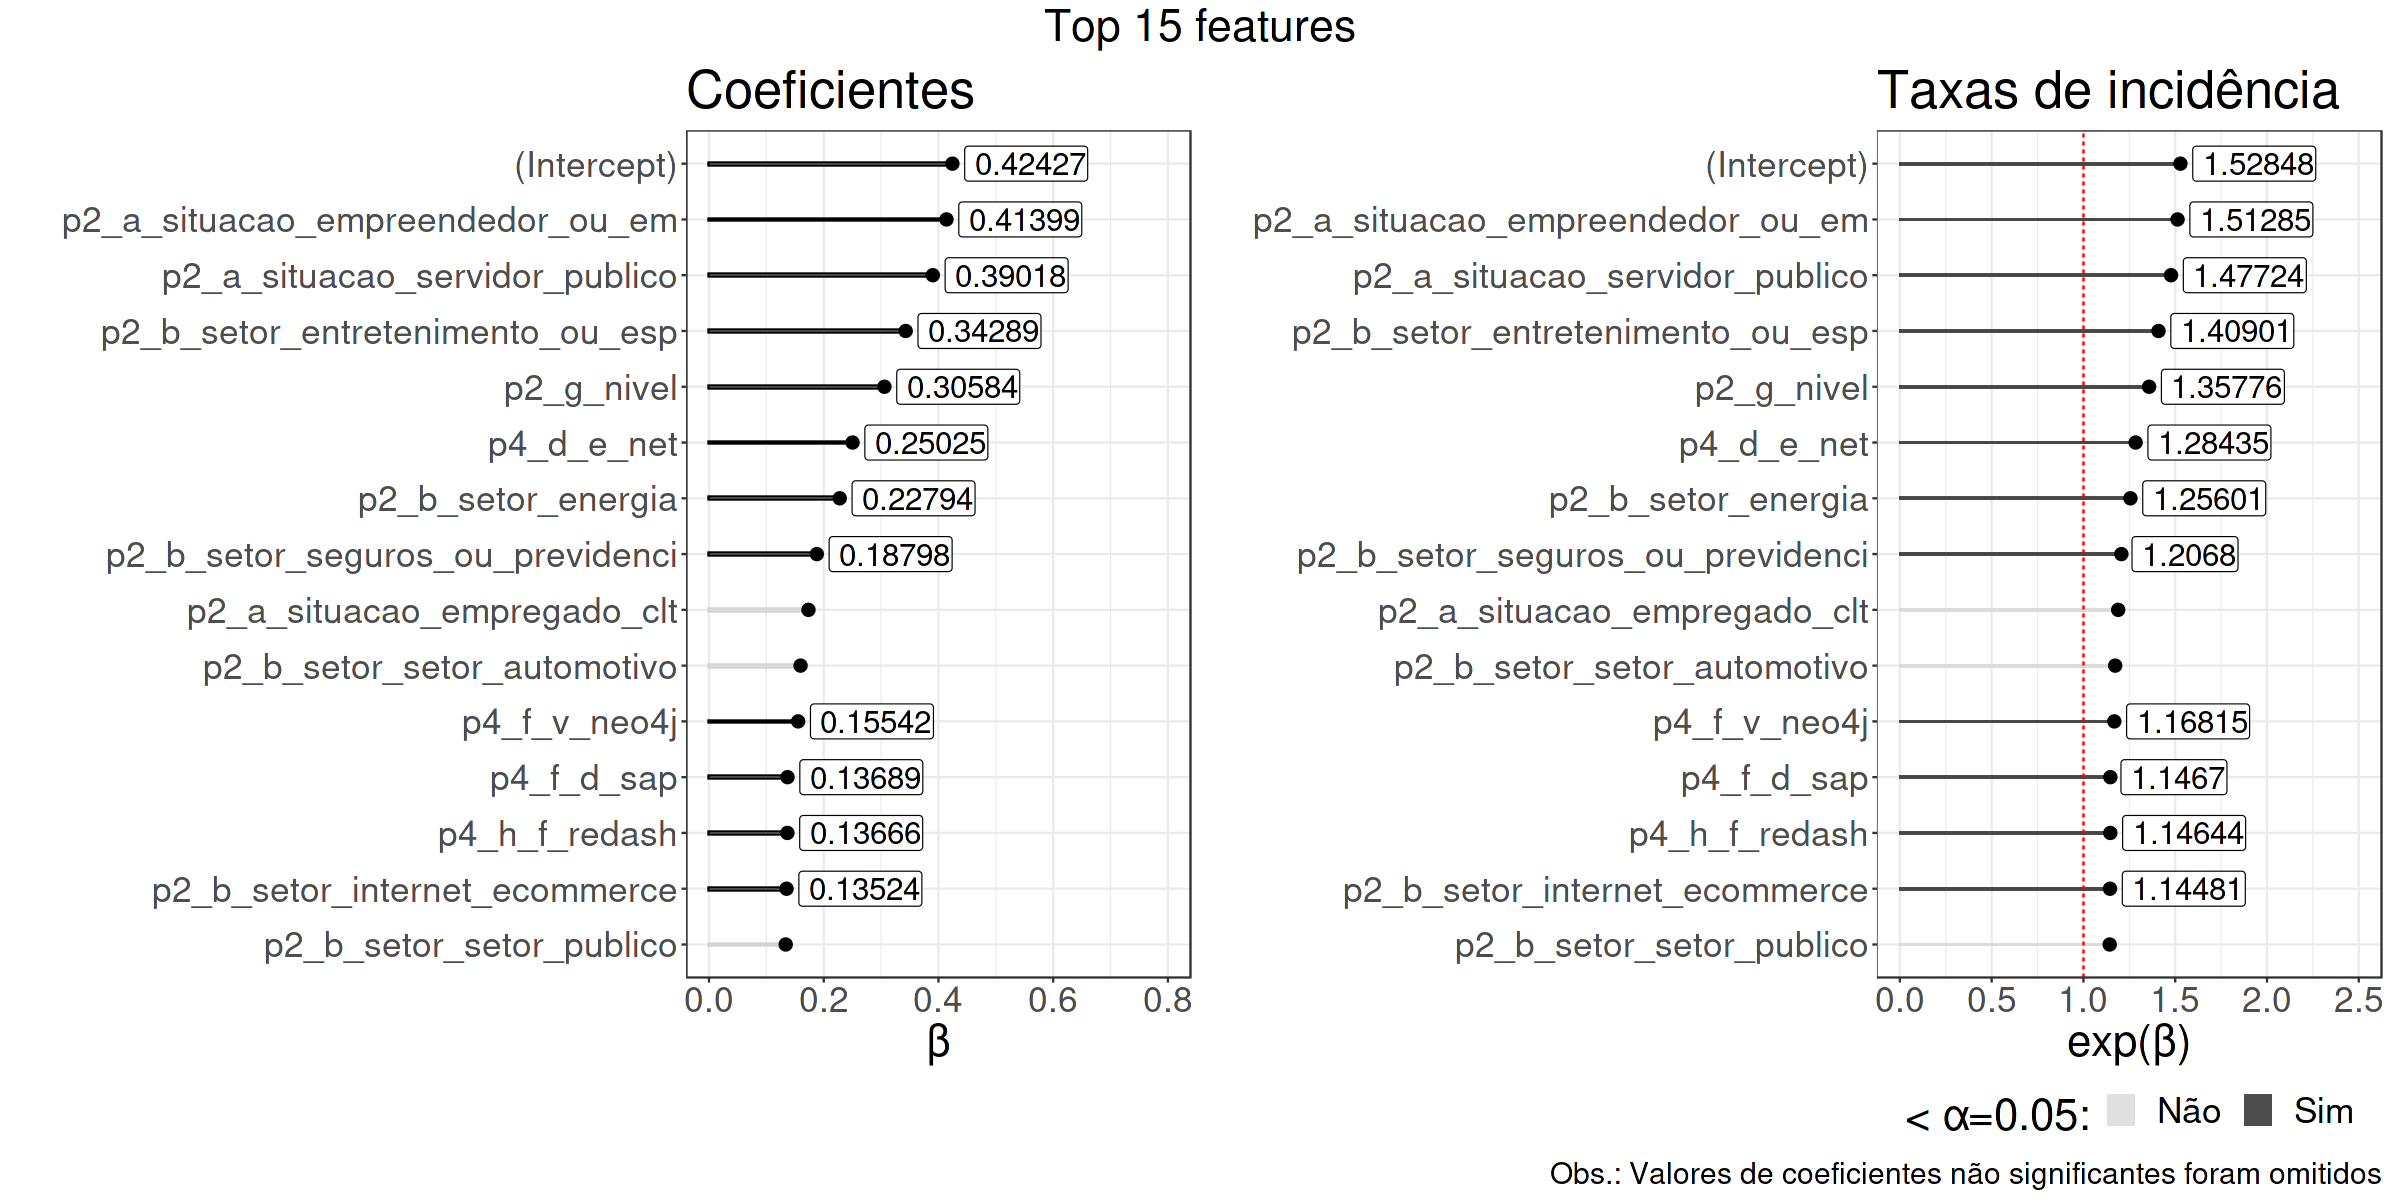

In [22]:
fig(20, 10)

p1 <- tibble(feature = names(model$mu.coefficients),
       coef = model$mu.coefficients)%>%
    na.omit() %>%
    mutate(p_value = summary_model[-nrow(summary_model),'Pr(>|t|)'],
           sig = ifelse(p_value<=0.05, "Sim", "Não")) %>%
    top_n(15, coef) %>%
    mutate(feature = reorder(feature, coef))%>%
    ggplot(aes(x = coef, y=feature))+
    geom_bar(aes(col=sig), fill=NA, stat='identity', width=0.05)+
    geom_point(size=3)+
    geom_label(aes(label=ifelse(sig=="Sim", round(coef, 5), NA_character_)), size=6.5, hjust=-.1)+
    labs(x = "β", y="", title="Coeficientes")+
    scale_colour_manual(values = c("lightgrey", "black"))+
    theme(legend.position="none")+
    scale_x_continuous(limits=c(0, 0.8))+ 
    theme(text = element_text(size=26))

p2 <- tibble(feature = names(model$mu.coefficients),
       coef = exp(model$mu.coefficients))%>%
    na.omit() %>%
    mutate(p_value = summary_model[-nrow(summary_model),'Pr(>|t|)'],
           sig = ifelse(p_value<=0.05, "Sim", "Não")) %>%
    top_n(15, coef) %>%
    mutate(feature = reorder(feature, coef))%>%
    ggplot(aes(x = coef, y=feature))+
    geom_bar(aes(fill=sig), stat='identity', width=0.05, alpha=0.7)+
    geom_point(size=3)+
    geom_vline(xintercept=1, linetype="dashed", color = "red")+
    geom_label(aes(label=ifelse(sig=="Sim", round(coef, 5), NA_character_)), size=6.5, hjust=-.1) +
    labs(x = "exp(β)", y="", title="Taxas de incidência")+
    scale_fill_manual('< α=0.05:', values = c("lightgrey", "black"))+
    scale_x_continuous(limits=c(0, 2.5))+ 
    theme(text = element_text(size=26), legend.position='bottom')

(p1 | p2) + plot_annotation(title = 'Top 15 features',
                            caption = "Obs.: Valores de coeficientes não significantes foram omitidos",
                            theme = theme(plot.title = element_text(hjust = 0.5)))

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ A maior estimativa é para a indicadora <b>É empreendedor ou CNPJ</b>, com uma taxa de 1,5284 vezes maior para faixa de salário (mantendo as demais variáveis constantes), ou seja, 52,84% maior do que aqueles que não são;</div>
    
<div style="color: rgb(0, 0, 0);">→ A segunda maior estimativa é do coeficiente da indicadora <b>É servidor público?</b>, com uma taxa de 1,5128 vezes maior para faixa de salário, isto é, 51,28% maior do que aqueles que não são;</div>
    
<div style="color: rgb(0, 0, 0);">→ A quarta maior estimativa é do coeficiente estimado para o <b>Nível de carreira</b> (Júnior, Pleno e Senior), com uma taxa de 1,3557 logo, <b>para cada nível alcançado, o salário pode aumentar aproximadamente 35%</b>!! 😎;</div>
    
<div style="color: rgb(0, 0, 0);">→ As demais features são todas dummys então convido o leitor interessado a interpretá-las </div>
    


<div class="alert alert-warning"> 
<strong><div style="color: rgb(0, 0, 0);">💡  Insights:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ Aparentemente os respondentes empreendedores, CNPJ e concursados são aqueles que possuem as maiores faixas de salários;</div>
<div style="color: rgb(0, 0, 0);">→ Os setores de entretenimento/esportes,  energia, seguradoras e internet/ecommerce parecem estar pagando os maiores salários;</div>
<div style="color: rgb(0, 0, 0);">→ Pelo visto, está valendo a pena investir na carreira de cientista de dados, pois aumentos de aproximadamente 35 <del>fucking</del> por cento não devem estar na média do mercado brasileiro atualmente 😲 </div>

Agora vejamos os valores dos coeficientes com menores estimativas e algumas interpretações:

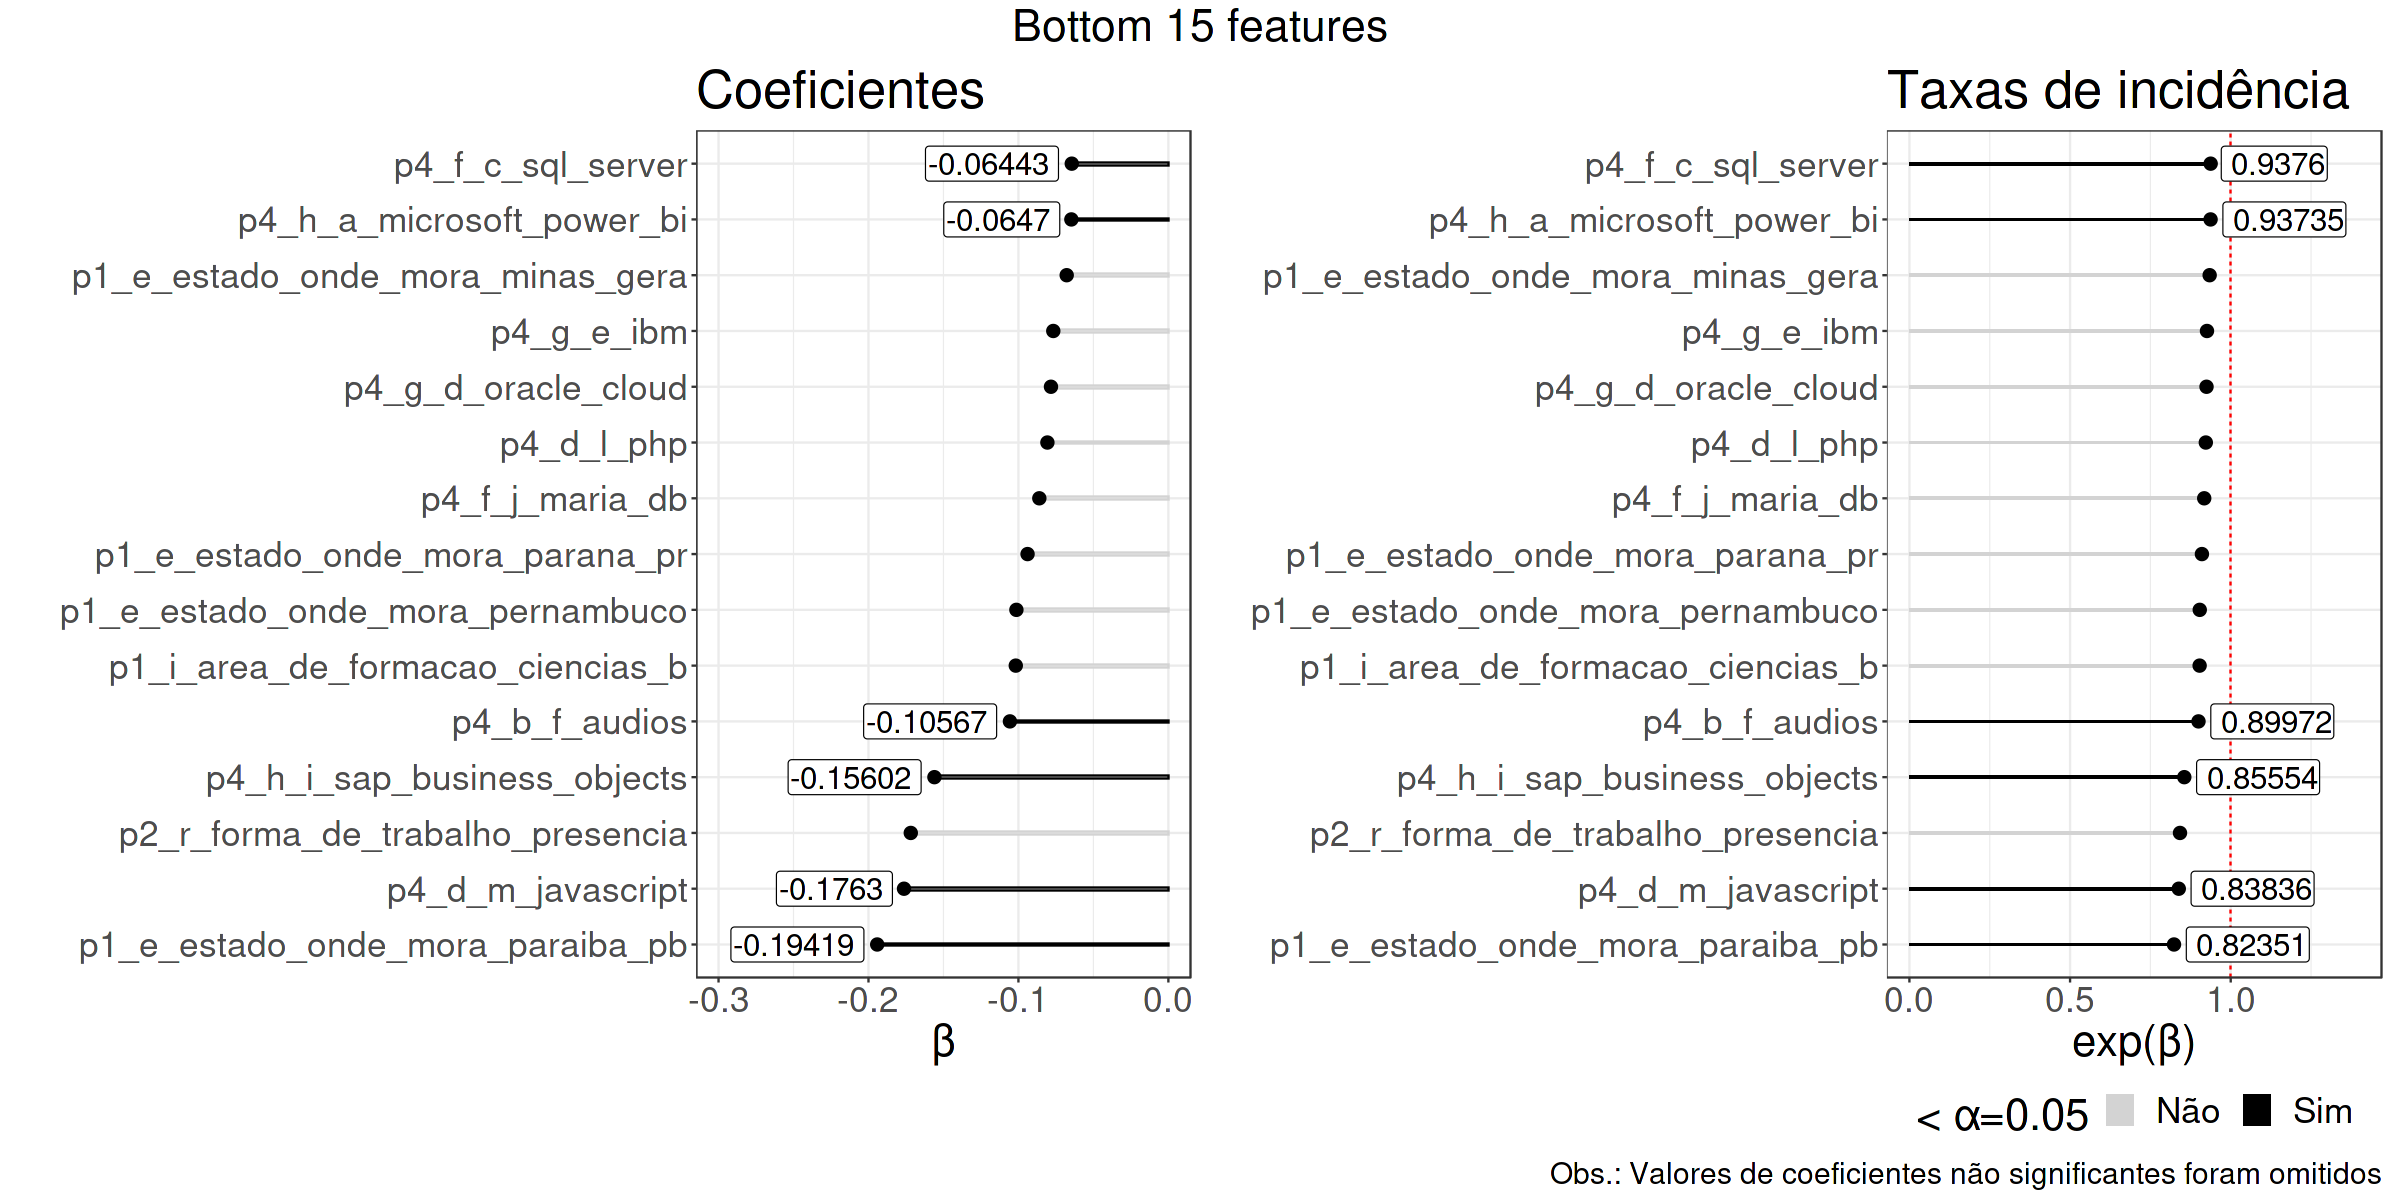

In [23]:
fig(20, 10)

p1 <- tibble(feature = names(model$mu.coefficients),
       coef = model$mu.coefficients)%>%
    na.omit() %>%
    mutate(p_value = summary_model[-nrow(summary_model),'Pr(>|t|)'],
           sig = ifelse(p_value<=0.05, "Sim", "Não")) %>%
    top_n(15, -coef) %>%
    mutate(feature = reorder(feature, coef))%>%
    ggplot(aes(x = coef, y=feature))+
    geom_bar(aes(col=sig), fill=NA, stat='identity', width=0.05)+
    geom_point(size=3)+
    geom_label(aes(label=ifelse(sig=="Sim", round(coef, 5), NA_character_)), size=6.5, hjust=1.1)+
    labs(x = "β", y="", title="Coeficientes")+
    scale_colour_manual(values = c("lightgrey", "black"))+
    theme(legend.position="none")+
    scale_x_continuous(limits=c(-.3, 0))+ 
    theme(text = element_text(size=26))

p2 <- tibble(feature = names(model$mu.coefficients),
       coef = exp(model$mu.coefficients))%>%
    na.omit() %>%
    mutate(p_value = summary_model[-nrow(summary_model),'Pr(>|t|)'],
           sig = ifelse(p_value<=0.05, "Sim", "Não")) %>%
    top_n(15, -coef) %>%
    mutate(feature = reorder(feature, coef))%>%
    ggplot(aes(x = coef, y=feature))+
    geom_bar(aes(fill=sig), stat='identity', width=0.05)+
    geom_point(size=3)+
    geom_vline(xintercept=1, linetype="dashed", color = "red")+
    geom_label(aes(label=ifelse(sig=="Sim", round(coef, 5), NA_character_)), size=6.5, hjust=-.1) +
    labs(x = "exp(β)", y="", title = "Taxas de incidência")+
    scale_fill_manual('< α=0.05', values = c("lightgrey", "black"))+
    scale_x_continuous(limits=c(0, 1.4))+ 
    theme(text = element_text(size=26), legend.position='bottom')

(p1 | p2) + plot_annotation(title = 'Bottom 15 features',
                            caption = "Obs.: Valores de coeficientes não significantes foram omitidos",
                            theme = theme(plot.title = element_text(hjust = 0.5)))

<div class="alert alert-info"> 
<strong><div style="color: rgb(0, 0, 0);">📌  Interpretação:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ A menor estimativa é para a indicadora <b>Mora na paraíba?</b>, com 0,8251 vezes faixa de salário para quem não mora lá (mantendo as outras variáveis constantes). Acontece que só temos apenas 21 respondentes que satisfazem as restrições para o modelo e um estudo mais detalhado sobre seu perfil pode ser necessário;</div>
    
<div style="color: rgb(0, 0, 0);">→ A segunda menor estimativa é do coeficiente da indicadora <b>Utiliza linguagem javascript?</b>, com 0,8383 a faixa de salário para quem usa essa linguagem. Faz sentido pois essa linguagem não é tão utilizada em data science e pode refletir candidatos que estão mudando de área e ainda estão se desenvolvendo em linguagens como R e Python;</div>
    
<div style="color: rgb(0, 0, 0);">→ A terceira menor estimativa é do coeficiente da indicadora para aqueles que <b>preferem trabalho presencial</b>, porém seu coeficiente não foi significativo então suas estimativas podem não ser tão confiáveis (inconclusivo);</div>
    
<div style="color: rgb(0, 0, 0);">→ As demais features são todas dummys então convido o leitor interessado a interpretá-las.</div>


<div class="alert alert-warning"> 
<strong><div style="color: rgb(0, 0, 0);">💡  Insights:</div></strong> <br>

<div style="color: rgb(0, 0, 0);">→ A maioria das features com os menores coeficientes estão relacionadas com <b>região</b> aonde mora, o que pode ser reflexo da concentração de oportunidades nas empresas que estão localizadas nas captais (nem todas aceitam 100% home office);</div>
<div style="color: rgb(0, 0, 0);">→ Algumas sinalizam o uso de ferramentas relacionadas à <b>BI</b> e gerenciamento de <b>bancos de dados</b>, o que pode estar relacionado com as pessoas que estão tentando migrar de área em busca de maiores salários;</div>

# SmartPay em ação!
---

É hora de conferir os resultados da calculadora na prática! 

Vamos criar alguns personagens fictícios e tentar estimar qual seria sua faixa de salário baseado em suas informações <b>técnicas</b> coletadas via questionário.

## Primeiro personagem

Seu Flávio é formado em ciência da computação, tem 55 anos, mora em São Paulo e está tentando uma vaga em engenharia de dados em uma Startup de 50 funcionários. A responsável do RH não sabe muito bem quanto pagar a ele e gostaria de oferecer um salário compatível com o mercado. Após anotar algumas informações deste candidato, ela os insere na ferramenta **SmartPay**:

<div style='border: 1px solid black;border-radius: 1%;background-color: #FFFBEB;'>

<div style="display: flex;flex: row;">

<div>
</br>
<b>&nbsp;Ficha do candidato:</b>
    
<ul>
  <li><b>Forma de trabalho:</b> Hibrido;</li>
  <li><b>Qual tipo de atuação:</b> Engenheiro de Dados;</li>
  <li><b>Área de Formação:</b> Ciencia da computação;</li>
  <li><b>Estado onde mora:</b> São Paulo;</li>
  <li><b>Setor da empresa:</b> Energia;</li>
  <li><b>Situacao (freela, clt, cnpj):</b> CLT;</li>
  <li><b>Nivel de ensino:</b> Pós Grduação (ordinal:3);</li>
  <li><b>Número de funcionarios na empresa:</b> Empresa pequena de 55 funcionários (ordinal:4);</li>
  <li><b>Nível do cargo (Júnior, Pleno, Sênior):</b> Sênior (ordinal:3);</li>
  <li><b>Quanto tempo de experiencia em Data Science:</b> Nenhuma experiencia (orginal:0);</li>
  <li><b>Quanto tempo de experiencia em TI:</b> + de 10 anos (ordinal:6);</li>
  <li><b>Esta satisfeito aonde esta?:</b> Não;</li>
  <li><b>Quais fontes de dados:</b> Bancos de dados relacionais, estruturados, armazenados no sql;</li>
  <li><b>Qual da linguagens vc usa:</b> SQL, Python, C++, VBA;</li>
  <li><b>Quais bancos de dados usa no trabalho:</b> MySQL, Orcle, SQL Server, SAP, Cassandra, MongoDB, S3, Postgree, Elastic, SQLite, BigQuery, Redshift, Databricks, Hive;</li>
  <li><b>Qual tipo de cloud: </b> AWS, Azure, On primisse;</li>
  <li><b>Qual tipo de ferramenta de BI: </b> Qlik View.</li>
</ul>


</div>
    
<div style="text-align: left; margin-left: 50px; margin-top: 70px;">
<img src="https://i.im.ge/2022/07/12/u4dZGC.png" width="200px" height="500px">
    
</div>
</div>


In [24]:
to_pred1 <- to_model %>% 
    mutate_all(~0) %>% 
    slice(1) %>%
    mutate(p2_r_forma_de_trabalho_hibrido=1,
            p4_a_atuacao_engenharia_de_dados=1,
            p1_i_area_de_formacao_computacao=1,
            p1_e_estado_onde_mora_sao_paulo_=1,
            p2_b_setor_energia=1,
            p2_a_situacao_empregado_clt=1,
            p1_h_nivel_de_ensino=3,
            p2_c_numero_de_funcionarios=4,
            p2_g_nivel=3,
            p2_i_quanto_tempo_de_experiencia=0,
            p2_j_quanto_tempo_de_experiencia=6,
            p2_k_voce_esta_satisfeito_na_sua=0,
            p4_b_a_dados_relacionais_estrutu=1,
            p4_b_b_dados_armazenados_em_banc=1,
            p4_b_g_planilhas=1,                
            p4_d_a_sql=1,
            p4_d_c_python=1,            
            p4_d_d_c_c_c_number=1,
            p4_d_i_visual_basic_vba=1,
            p4_f_a_my_sql=1,
            p4_f_b_oracle=1,
            p4_f_c_sql_server=1,
            p4_f_d_sap=1,                      
            p4_f_h_cassandra=1,
            p4_f_i_mongo_db=1,                 
            p4_f_l_s3=1,
            p4_f_m_postgre_sql=1,
            p4_f_n_elastic_search=1,           
            p4_f_q_sq_lite=1,
            p4_f_x_google_big_query=1,
            p4_f_z_amazon_redshift=1,
            p4_f_z3_databricks=1,
            p4_f_z8_hive=1,                    
            p4_g_a_amazon_web_services_aws=1,
            p4_g_c_azure_microsoft=1,
            p4_g_f_servidores_on_premise_nao=1,
            p4_h_b_qlik_view_qlik_sense=1
          )

Veja o resultado informado pelo **SmartPay**:

In [25]:
pred1 <- predict(model, newdata=to_pred1, what="mu", type="response")
glue::glue("💰 O salário previsto para este funcionário é de aproximadamente : R${scales::comma(pred1*1000, big.mark = '.', decimal.mark = ',', accuracy = 0.01)}")

💰 O salário previsto para este funcionário é de aproximadamente : R$13.341,39

In [26]:
# Calcular intervalo de confianca (nao deu tempo)
#predicted = predict(model, newdata=to_pred1, what="mu", type='link', se.fit=TRUE)

#se_high = exp(predicted$fit + (predicted$se.fit*1.96))
#se_low = exp(predicted$fit - (predicted$se.fit*1.96))
#expected = exp(predicted$fit)

Obs.: Eu não sei se isto é um salário justo para um engenheiro de dados com essas *skills* pois não é minha área de atuação, se tiver algum especialista iria adorar ouvir se esta predição faz sentido! 

## Outro personagem

Suponha que uma *tech recruiter* precisa encontrar, com urgência, algum cientista de dados para um cliente da área da saúde (empresa média, de 550 funcionários) e resolve abordar Ana para uma vaga de nível Pleno. Mesmo percebendo que Ana não informa que está "procurando por novas oportunidades" no Linkedin, resolve abordá-la para entrevista e durante a conversa, coleta dados importantes para avaliar se tem *fit* com a vaga. Após a entrevista, ela consulta o <b>SmartPay</b> para compreender qual seria um salário compatível com o mercado e tentar fazer uma proposta mais agressiva para incentivar sua mudança.

<div style='border: 1px solid black;border-radius: 1%;background-color: #FFFBEB;'>

<div style="display: flex;flex: row;">

<div>
</br>
<b>&nbsp;Ficha do candidato:</b>
    
<ul>
  <li><b>Forma de trabalho:</b> Home office;</li>
  <li><b>Qual tipo de atuação:</b> Cientista de dados;</li>
  <li><b>Área de Formação:</b> Ciências Biológicas;</li>
  <li><b>Estado onde mora:</b> Bahia;</li>
  <li><b>Setor da empresa:</b> Área da saúde;</li>
  <li><b>Situacao (freela, clt, cnpj):</b> CLT;</li>
  <li><b>Nivel de ensino:</b> Doutorado (ordinal:4);</li>
  <li><b>Número de funcionarios na empresa:</b> 550 (ordinal:6);</li>
  <li><b>Nível do cargo (Júnior, Pleno, Sênior):</b> Pleno (ordinal:2);</li>
  <li><b>Quanto tempo de experiencia em Data Science:</b> 5 anos (orginal:4);</li>
  <li><b>Quanto tempo de experiencia em TI:</b> nenhuma experiência (ordinal:0);</li>
  <li><b>Esta satisfeito aonde esta?:</b> Sim;</li>
  <li><b>Quais fontes de dados: </b> Bandos de dados relacionais estruturados, sql, documentos de texto, planilhas e georeferencias;</li>
  <li><b>Qual da linguagens vc usa:</b> SQL, R e Python;</li>
  <li><b>Quais bancos de dados usa no trabalho:</b> MySQL, Oracle, SQLSserver, MongoDB, S3, PostgreSQL, SQLite, Databricks;</li>
  <li><b>Qual tipo de cloud: </b> GCP e Azure;</li>
  <li><b>Qual tipo de ferramenta de BI: </b> Nenhuma.</li>
</ul>

</div>
    
<div style="text-align: right; margin-left: 50px; margin-top: 70px;">
<img src="https://i.im.ge/2022/07/12/u4dbwh.png" width="200px" height="200px">
    
</div>
</div>



In [27]:
to_pred2 <- to_model %>% 
    mutate_all(~0) %>% 
    slice(1) %>%
    mutate(p2_r_forma_de_trabalho_remoto=1,
    p4_a_atuacao_ciencia_de_dados=1,
    p1_i_area_de_formacao_ciencias_b=1,
    p1_e_estado_onde_mora_bahia_ba=1,
    p2_b_setor_area_da_saude=1,
    p2_a_situacao_empregado_clt=1,
    p2_a_situacao_freelancer=1,
    p1_h_nivel_de_ensino=4,
    p2_c_numero_de_funcionarios=6,
    p2_g_nivel=2,
    p2_i_quanto_tempo_de_experiencia=4,
    p2_j_quanto_tempo_de_experiencia=0,
    p2_k_voce_esta_satisfeito_na_sua=1,
    p4_b_a_dados_relacionais_estrutu=1,
    p4_b_b_dados_armazenados_em_banc=1,
    p4_b_d_textos_documentos=1,
    p4_b_g_planilhas=1,               
    p4_b_h_dados_georeferenciados=1,
    p4_d_a_sql=1,
    p4_d_b_r=1,
    p4_d_c_python=1,
    p4_f_a_my_sql=1,
    p4_f_b_oracle=1,
    p4_f_c_sql_server=1,
    p4_f_i_mongo_db=1,
    p4_f_l_s3=1,
    p4_f_m_postgre_sql=1,
    p4_f_q_sq_lite=1,
    p4_f_z3_databricks=1,
    p4_g_b_google_cloud_gcp=1,
    p4_g_c_azure_microsoft=1
          )

In [28]:
pred2 <- predict(model, newdata=to_pred2, what="mu", type="response")
glue::glue("💰 O salário previsto para este funcionário é de aproximadamente : R${scales::comma(pred2*1000, big.mark = '.', decimal.mark = ',', accuracy = 0.01)}")

💰 O salário previsto para este funcionário é de aproximadamente : R$12.163,39

Para um(a) de cientista de dados de nível Pleno, com 5 anos de experiência trabalhando na área, até que temos um valor interessante. Você, que tem essas skils e experiência, mudaria de emprego por este salário?

## E tantos outros personagens..

Note que em nenhum momento o modelo teve contato com informações do candidato que pudessem **discriminá-los**. 

Omitir esse tipo de informação mantém o computador longe de possíveis vieses presentes na base (que infelizmente refletem problemas estruturais da sociedade) e permite a construção de um ambiente mais diverso, onde pessoas com histórias muito diferentes possam compartilhar suas experiências, criando assim, um belo "*ensemble* criativo".

![](https://i.im.ge/2022/07/12/u4LpnD.png)

In [29]:
# Para ajudar a criar mais personagens

#ver categorias descritivas do cadidato
# print(colnames(to_model)[1:55]) 

# Skills para ohe
# p4_b_a_dados_relacionais_estrutu
# p4_b_b_dados_armazenados_em_banc
# p4_b_c_imagens                  
# p4_b_d_textos_documentos
# p4_b_e_videos                   
# p4_b_f_audios
# p4_b_g_planilhas                
# p4_b_h_dados_georeferenciados
# p4_d_a_sql                      
# p4_d_b_r
# p4_d_c_python                   
# p4_d_d_c_c_c_number
# p4_d_e_net                      
# p4_d_f_java
# p4_d_h_sas_stata                
# p4_d_i_visual_basic_vba
# p4_d_j_scala                    
# p4_d_l_php
# p4_d_m_javascript               
# p4_f_a_my_sql
# p4_f_b_oracle                   
# p4_f_c_sql_server
# p4_f_d_sap                      
# p4_f_e_amazon_aurora_ou_rds
# p4_f_f_amazon_dynamo_db         
# p4_f_h_cassandra
# p4_f_i_mongo_db                 
# p4_f_j_maria_db
# p4_f_l_s3                       
# p4_f_m_postgre_sql
# p4_f_n_elastic_search           
# p4_f_o_db2
# p4_f_p_microsoft_access         
# p4_f_q_sq_lite
# p4_f_s_firebase                 
# p4_f_u_redis
# p4_f_v_neo4j                    
# p4_f_x_google_big_query
# p4_f_y_google_firestore         
# p4_f_z_amazon_redshift
# p4_f_z1_amazon_athena           
# p4_f_z2_snowflake
# p4_f_z3_databricks              
# p4_f_z4_h_base
# p4_f_z5_presto                  
# p4_f_z7_sap_hana
# p4_f_z8_hive                    
# p4_g_a_amazon_web_services_aws
# p4_g_b_google_cloud_gcp         
# p4_g_c_azure_microsoft
# p4_g_d_oracle_cloud             
# p4_g_e_ibm
# p4_g_f_servidores_on_premise_nao
# p4_g_g_cloud_propria
# p4_h_a_microsoft_power_bi       
# p4_h_b_qlik_view_qlik_sense
# p4_h_c_tableau                  
# p4_h_d_metabase
# p4_h_e_superset                 
# p4_h_f_redash
# p4_h_g_micro_strategy           
# p4_h_i_sap_business_objects
# p4_h_k_amazon_quick_sight       
# p4_h_l_salesforce_einstein_analy
# p4_h_n_alteryx                  
# p4_h_q_google_data_studio
# p4_h_r_sas_visual_analytics     
# p4_h_s_grafana
# p4_h_u_pentaho                  
# p4_h_v_fazemos_todas_as_analises
# p4_h_x_nao_utilizo_nenhuma_ferra

# Próximos passos 🚀 
---

Queria testar mais algumas abordagens mas como [Cronos](https://pt.wikipedia.org/wiki/Cronos#:~:text=Cronos%20(em%20grego%3A%20%CE%9A%CF%81%CF%8C%CE%BD%CE%BF%CF%82%2C,velhos%20de%20Oceano%20e%20T%C3%A9tis.) não parece gostar muito de mim, tive o tempo muito reduzido para trabalhar nesta competição, assim a priorização de determinadas tarefas foi fundamental. 

Vou deixar possíveis próximos passos como sugestão para aprimoramento do modelo (quem sabe em uma competição no próximo ano? 🥵):

- Tentar ajustar um glm com resposta multinomial para prever as faixas de salários e comparar com binomial negativa; 
- Utilizar modelos de Machine Learning baseados em árvore (como Decision Trees, XGBoost, LightGBM e CatBoost) com `objective="Poisson"` para buscar modelos melhores e, consequentemente, com maior R²;
- Explorar mais os dados, tentar feature engineering, feature selection, tuning de diferentes modelos de Machine Learning;
- Tratar alguns outliers de maneira mais efetiva, em vez de removê-los;
- Adicionar dados externos (por exemplo dados econômicos);
- Ensembles;
- Desenvolver app shiny para captar inputs e exibir estimativas;
- Etc

Adoraria ouvir mais algumas idéia de abordagens para resolver este problema, é um dataset repleto de possibilidades!

# Conclusão e discussão final
---

Vimos que a alta demanda de profissionais de dados, acompanhada de baixa oferta, tem sugerido altos valores de salários e talvez isso não dure para sempre.

Já vimos diversos episódios de demissões em massa em empresas de diversos setores, também conhecidos como <i>layoffs</i> ([veja esta noticia](https://veja.abril.com.br/coluna/radar-economico/marcado-pelo-risco-setor-de-inovacao-registra-mais-nova-demissao-em-massa/)).Isso é um reflexo de diversos fatores da atualidade (primeiro semestre de 2022) que têm abalado a economia mundialmente. E quando o mercado acumula gente demais e de repente a demanda some, quem você acha que as empresas mantém?


## Bolha? <img src="https://img1.picmix.com/output/stamp/normal/9/9/1/6/1496199_a2798.gif" align="right" width="100px" height="50px" />


Naturamente, surge a seguinte <b>pergunta:</b> E se, por acaso, essa bolha estourar, o que acontecerá com os cientistas de dados?

Antes de tudo, um bom cientista de dados deve analisar dados e testar diferentes métodos estatísticos/computacionais simplismente pelo fato de que gosta de fazer isso. Apreciar o que está fazendo certamente é um caminho para se tornar um ótimo profissional. 

> Se você perguntar para o músico o que ele mais gosta de fazer, ele provavelmente dirá que o que mais gosta é tocar com outros bons músicos.

Um cientista de dados nunca vai sair do lugar se tiver fazendo a mesma coisa todos os dias, por isso é importante estar antenado nas novidades, trocar idéias com colegas e se desafiar a fazer coisas diferentes, acumulando experiência. Assim como seguir receitas prontas não torna ninguém um chef de cozinha, só copiar e colar código não tornará alguém bom. É claro que tudo tem um começo mas é importante reconhecer que estamos em uma jornada.

Então acho que a <b>resposta</b> para a pergunta inicial é a seguinte: Se você se manteve consistente, acumulou conhecimento, prática, foi capaz de entregar o que promete (tempo, custo e qualidade) e as vezes surpreende, entregando mais do que o esperado, você sempre terá empregos bem remunerados, independente se estamos em crise ou não.

<b>Resposta resumida</b>: "Se foi fácil chegar até aonde você chegou, diria que é preciso tomar cuidado pois foi fácil para outras pessoas também" ([A Bolha de Startups vai Estourar? | Winter is Coming](https://www.youtube.com/watch?v=wpPv1dJWjDs))




## Chegamos ao fim! 

Fico muito feliz de ver esta pesquisa evoluindo tão bem! Tive a oportunidade de fazer algumas análises na pesquisa do final de 2019 e quis aproveitar essa oportunidade para praticar e tentar ousar em uma abordagem mais estatística do que machine learning dessa vez ()

Parabéns a todos os participantes que fizeram notebooks tão incríveis! Foram muitas horas fora do trabalho para participar desta competição e torná-la tão legal! Parabéns também aos organizadores da pesquisa e da competição por trazer dados tão importantes sobre nossa área.

Boa sorte a todos!  <img src="https://media0.giphy.com/avatars/HeyAutoHQ/DgfrJNR8oUyv.gif" align="right" width="100px" height="10px" />




# Referências
---

- <https://stats.oarc.ucla.edu/r/dae/negative-binomial-regression/>
- <https://www.gamlss.com/diagnostics/>
- <https://www.gamlss.com/wp-content/uploads/2013/01/book-2010-Athens1.pdf>
- <http://www.gamlss.com/wp-content/uploads/2013/01/gamlss-manual.pdf>
- <https://stats.stackexchange.com/questions/247183/interpret-residual-vs-fitted-values-for-negative-binomial-glm>